### KEYS

In [1]:
import json
import pandas as pd
import numpy as np
from numpy import random
import math
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.figure import Figure
from matplotlib.ticker import MaxNLocator
from matplotlib.gridspec import GridSpec
import seaborn as sns
import scipy
from scipy import stats
from scipy.stats import mannwhitneyu
from scipy.stats import fligner
from scipy.stats import skewtest
stats.junk = lambda chisq, df: stats.chi2.sf(chisq, df)
import csv
import gffpandas.gffpandas as gffpd
import sklearn
from sklearn.metrics import r2_score
import os
import statistics
%load_ext rpy2.ipython

#### DATAFRAME RECORDING THE GENERATION TIME PER SAMPLE ####
dic_gen = {'CC2344-L1': 912.356113, 'CC2344-L10': 917.129696, 'CC2344-L11': 889.5859554, 'CC2344-L12': 950.0552184, 'CC2344-L13': 961.4186064,
           'CC2344-L14': 931.447801, 'CC2344-L15': 946.6643063, 'CC2344-L2': 923.1078072, 'CC2344-L3': 1000.469526, 'CC2344-L4': 808.9505794,
           'CC2344-L5': 957.6380465, 'CC2344-L6': 970.6307256, 'CC2344-L7': 990.9451516, 'CC2344-L8': 1009.966123, 'CC2344-L9': 901.0619061, 
           'CC2931-L1': 1050.109001, 'CC2931-L10': 1097.978141, 'CC2931-L11': 1021.13559, 'CC2931-L13': 1041.362593, 
           'CC2931-L14': 1016.111493, 'CC2931-L15': 1052.540951, 'CC2931-L2': 1056.765369, 'CC2931-L3': 1000.399127, 'CC2931-L4': 1011.411706,
           'CC2931-L5': 993.8603657, 'CC2931-L6': 1083.095655, 'CC2931-L7': 1067.34507, 'CC2931-L9': 1079.236285}
generations = pd.Series(dic_gen)

#### DATAFRAME RECORDING THE NUMBER OF MUTATIONS PER SAMPLE ####
dic_mut = {'CC2344-L1': 396, 'CC2344-L10': 59, 'CC2344-L11': 46, 'CC2344-L12': 74, 'CC2344-L13': 49, 'CC2344-L14': 46, 'CC2344-L15': 53, 
           'CC2344-L2': 80, 'CC2344-L3': 63, 'CC2344-L4': 24, 'CC2344-L5': 68, 'CC2344-L6': 38, 'CC2344-L7': 45, 'CC2344-L8': 75, 'CC2344-L9': 27, 
           'CC2931-L1': 89, 'CC2931-L10': 87, 'CC2931-L11': 85, 'CC2931-L13': 97, 'CC2931-L14': 79, 'CC2931-L15': 141, 'CC2931-L2': 123,
           'CC2931-L3': 52, 'CC2931-L4': 100, 'CC2931-L5': 335, 'CC2931-L6': 84, 'CC2931-L7': 72, 'CC2931-L9': 113}
mutations = pd.Series(dic_mut)

# FPKM SECTION

### FUNCTION - FPKM TOOL 

In [49]:
def fpkm(gene_count, fragment_length):
    ''' Fragments Per Kilobase of transcript per Million mapped reads '''
    gene_count = gene_count.join([fragment_length])
    gene_count = gene_count.reset_index()

    gene_count.loc['sum'] = gene_count.sum(axis = 0)
    gene_count[gene_count.columns[1:]] = gene_count[gene_count.columns[1:]].astype(int)

    ## MULTIPLY BY 10^(9)
    gene_count.loc['sum', gene_count.columns[1:-1]] = pow(10,9)/gene_count.loc['sum'][gene_count.columns[1:-1]]
    FPKM = gene_count[:-1][gene_count.columns[1:-1]]

    ## DIVIDE BY TOTAL_READS
    for i in FPKM.columns:
        FPKM[i] = FPKM[i]*gene_count.at['sum', i]

    ## DIVIDE BY GENE_LENGTH
    for i in list(FPKM.index.values):
        FPKM.iloc[i] = FPKM.iloc[i]/gene_count.at[i, 'total_exon_length']

    FPKM = pd.concat([FPKM, gene_count['index'][:-1]], axis = 1)

    # REDO COLUMN LABELS
    FPKM = FPKM.set_index('index')
    columns = FPKM.columns.str.replace('.','-', regex = True)
    columns = columns.str.replace('_','-', regex = True)
    columns = columns.str.split('-')
    FPKM.columns = [columns[i][1] + '-' + columns[i][2] + '-' + columns[i][3] for i in range(len(columns))]
    return FPKM

### FPKM

In [50]:
#################################################
### IMPORTING NOISEQ PRE-FILTERED GENE COUNTS ###
#################################################
CC2344_counts = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/raw_counts/noiseq_filtered_unnormalized_CC2344.txt', delimiter = '\t')
CC2931_counts = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/raw_counts/noiseq_filtered_unnormalized_CC2931.txt', delimiter = '\t')
fragment_length = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/fpkm/fragment_length.csv', delimiter = '\t', index_col = 'Unnamed: 0')

CC2344_FPKM = fpkm(CC2344_counts, fragment_length)
CC2931_FPKM = fpkm(CC2931_counts, fragment_length)

## EXPORT
CC2344_FPKM.to_csv('/research/projects/chlamydomonas/MAexpression/analysis/fpkm/CC2344_fpkm', sep= '\t', index = True, header = True)
CC2931_FPKM.to_csv('/research/projects/chlamydomonas/MAexpression/analysis/fpkm/CC2931_fpkm', sep= '\t', index = True, header = True)

### COMPARING THE FPKM BETWEEN ANCESTRAL REPLICATES

/home/balogu15/.conda/envs/personal/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
<ipython-input-4-9e5e13f4ca07>:21: RuntimeWarning: divide by zero encountered in log
  a = a.replace(np.log(0), np.nan) ## replace np.log(0) with nothing
<ipython-input-4-9e5e13f4ca07>:22: RuntimeWarning: divide by zero encountered in log
  b = b.replace(np.log(0), np.nan)
<ipython-input-4-9e5e13f4ca07>:23: RuntimeWarning: divide by zero encountered in log
  c = c.replace(np.log(0), np.nan)
<ipython-input-4-9e5e13f4ca07>:24: RuntimeWarning: divide by zero encountered in log
  d = d.replace(np.log(0), np.nan)
<ipython-input-4-9e5e13f4ca07>:25: RuntimeWarning: divide by zero encountered in log
  e = e.replace(np.log(0), np.nan)
<ipython-input-4-9e5e13f4ca07>:26: RuntimeWarning: divide by zero encountered in log
  f = f.replace(np.log(0), np.nan)


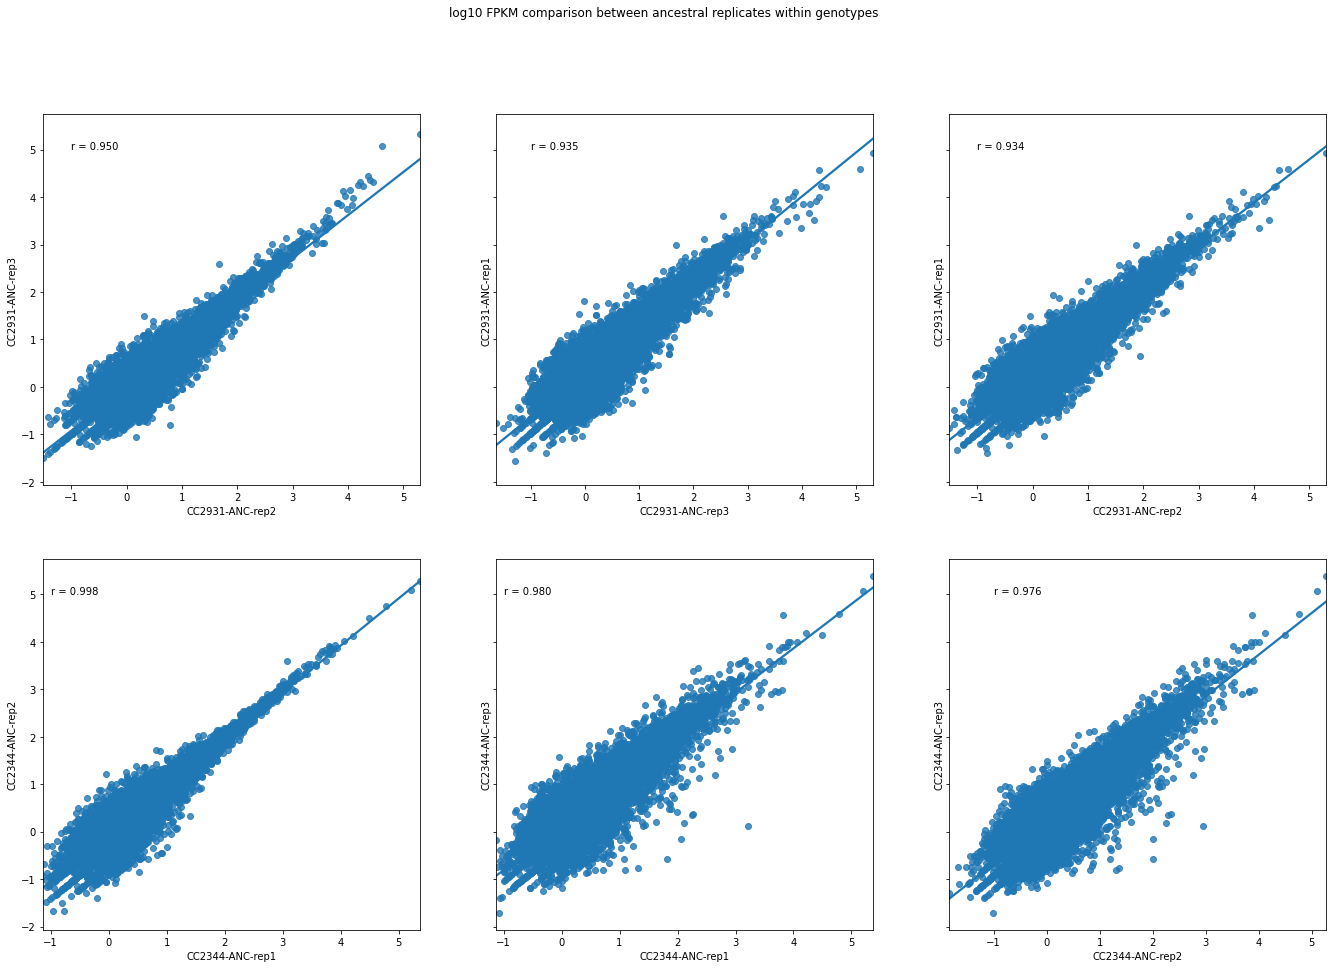

In [4]:
CC2931_FPKM = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/fpkm/CC2931_fpkm', delimiter = '\t')
CC2344_FPKM = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/fpkm/CC2344_fpkm', delimiter = '\t')
CC2931_FPKM = CC2931_FPKM.dropna()
CC2344_FPKM = CC2344_FPKM.dropna()

#### TAKING THE LOG10 OF VALUES AND EXCLUDING ZEROS ####
a = np.log10(CC2931_FPKM['CC2931-ANC-rep2'])
b = np.log10(CC2931_FPKM['CC2931-ANC-rep3'])
c = np.log10(CC2931_FPKM['CC2931-ANC-rep1'])
d = np.log10(CC2344_FPKM['CC2344-ANC-rep1'])
e = np.log10(CC2344_FPKM['CC2344-ANC-rep2'])
f = np.log10(CC2344_FPKM['CC2344-ANC-rep3'])

# a = a.replace(np.log(0), 0)
# b = b.replace(np.log(0), 0)
# c = c.replace(np.log(0), 0)
# d = d.replace(np.log(0), 0)
# e = e.replace(np.log(0), 0)
# f = f.replace(np.log(0), 0)

a = a.replace(np.log(0), np.nan) ## replace np.log(0) with nothing
b = b.replace(np.log(0), np.nan)
c = c.replace(np.log(0), np.nan)
d = d.replace(np.log(0), np.nan)
e = e.replace(np.log(0), np.nan)
f = f.replace(np.log(0), np.nan)

## The R value is based on the non-log10 scaled values

fig, axes = plt.subplots(2, 3, figsize=(23, 15), sharey=True)
fig.suptitle('log10 FPKM comparison between ancestral replicates within genotypes')

sns.regplot(ax = axes[0,0], data = CC2931_FPKM, x = a, y = b, ci = False)
axes[0,0].annotate("r = {:.3f}".format(scipy.stats.pearsonr(CC2931_FPKM['CC2931-ANC-rep2'], CC2931_FPKM['CC2931-ANC-rep3'])[0]), (-1,5))

sns.regplot(ax = axes[0,1], data = CC2931_FPKM, x = b, y = c, ci = False)
axes[0,1].annotate("r = {:.3f}".format(scipy.stats.pearsonr(CC2931_FPKM['CC2931-ANC-rep3'], CC2931_FPKM['CC2931-ANC-rep1'])[0]), (-1,5))

sns.regplot(ax = axes[0,2], data = CC2931_FPKM, x = a, y = c, ci = False)
axes[0,2].annotate("r = {:.3f}".format(scipy.stats.pearsonr(CC2931_FPKM['CC2931-ANC-rep2'], CC2931_FPKM['CC2931-ANC-rep1'])[0]), (-1,5))

sns.regplot(ax = axes[1,0], data = CC2344_FPKM, x = d, y = e, ci = False)
axes[1,0].annotate("r = {:.3f}".format(scipy.stats.pearsonr(CC2344_FPKM['CC2344-ANC-rep1'], CC2344_FPKM['CC2344-ANC-rep2'])[0]), (-1,5))

sns.regplot(ax = axes[1,1], data = CC2344_FPKM, x = d, y = f, ci = False)
axes[1,1].annotate("r = {:.3f}".format(scipy.stats.pearsonr(CC2344_FPKM['CC2344-ANC-rep1'], CC2344_FPKM['CC2344-ANC-rep3'])[0]), (-1,5))

sns.regplot(ax = axes[1,2], data = CC2344_FPKM, x = e, y = f, ci = False)
axes[1,2].annotate("r = {:.3f}".format(scipy.stats.pearsonr(CC2344_FPKM['CC2344-ANC-rep2'], CC2344_FPKM['CC2344-ANC-rep3'])[0]), (-1,5))

fig.savefig('/research/projects/chlamydomonas/MAexpression/analysis/fpkm/within_genotype_ancestral_replicate_comparison.pdf', format = 'pdf', dpi = 150, bbox_inches = 'tight')

/home/balogu15/.conda/envs/personal/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
<ipython-input-5-911ebde3ae42>:31: RuntimeWarning: divide by zero encountered in log
  a = a.replace(np.log(0), np.nan) ## replace np.log(0) with nothing
<ipython-input-5-911ebde3ae42>:32: RuntimeWarning: divide by zero encountered in log
  b = b.replace(np.log(0), np.nan)
<ipython-input-5-911ebde3ae42>:33: RuntimeWarning: divide by zero encountered in log
  c = c.replace(np.log(0), np.nan)
<ipython-input-5-911ebde3ae42>:34: RuntimeWarning: divide by zero encountered in log
  d = d.replace(np.log(0), np.nan)
<ipython-input-5-911ebde3ae42>:35: RuntimeWarning: divide by zero encountered in log
  e = e.replace(np.log(0), np.nan)
<ipython-input-5-911ebde3ae42>:36: RuntimeWarning: divide by zero encountered in log
  f = f.replace(np.log(0), np.nan)


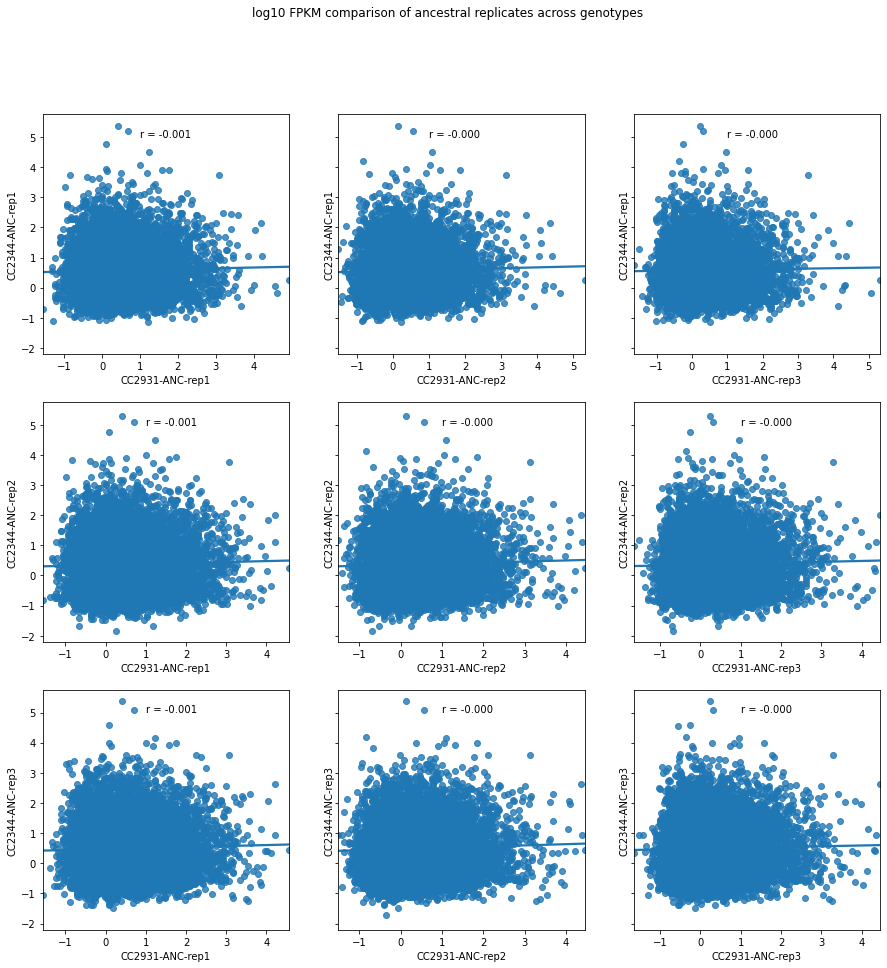

In [5]:
CC2931_FPKM = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/fpkm/CC2931_fpkm', delimiter = '\t')
CC2344_FPKM = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/fpkm/CC2344_fpkm', delimiter = '\t')
CC2931_FPKM = CC2931_FPKM.dropna()
CC2344_FPKM = CC2344_FPKM.dropna()

combined = pd.DataFrame(columns = list(CC2931_FPKM.columns) + list(CC2344_FPKM.columns))
for i in combined.columns:
    if 'CC2344' in i:
        combined[i] = CC2344_FPKM[i]
    if 'CC2931' in i:
        combined[i] = CC2931_FPKM[i]
        
combined = combined.drop('index', axis = 1)
combined = combined.dropna()

#### TAKING THE LOG10 OF VALUES AND EXCLUDING ZEROS ####
a = np.log10(combined['CC2931-ANC-rep1'])
b = np.log10(combined['CC2931-ANC-rep2'])
c = np.log10(combined['CC2931-ANC-rep3'])
d = np.log10(combined['CC2344-ANC-rep1'])
e = np.log10(combined['CC2344-ANC-rep2'])
f = np.log10(combined['CC2344-ANC-rep3'])

# a = a.replace(np.log(0), 0)
# b = b.replace(np.log(0), 0)
# c = c.replace(np.log(0), 0)
# d = d.replace(np.log(0), 0)
# e = e.replace(np.log(0), 0)
# f = f.replace(np.log(0), 0)

a = a.replace(np.log(0), np.nan) ## replace np.log(0) with nothing
b = b.replace(np.log(0), np.nan)
c = c.replace(np.log(0), np.nan)
d = d.replace(np.log(0), np.nan)
e = e.replace(np.log(0), np.nan)
f = f.replace(np.log(0), np.nan)

## The R value is based on the non-log10 scaled values

fig, axes = plt.subplots(3, 3, figsize=(15, 15), sharey=True)
fig.suptitle('log10 FPKM comparison of ancestral replicates across genotypes')

sns.regplot(ax = axes[0,0], data = combined, x = a, y = d, ci = False)
axes[0,0].annotate("r = {:.3f}".format(scipy.stats.pearsonr(combined['CC2931-ANC-rep1'], combined['CC2344-ANC-rep1'])[0]), (1,5))

sns.regplot(ax = axes[0,1], data = combined, x = b, y = d, ci = False)
axes[0,1].annotate("r = {:.3f}".format(scipy.stats.pearsonr(combined['CC2931-ANC-rep2'], combined['CC2344-ANC-rep1'])[0]), (1,5))

sns.regplot(ax = axes[0,2], data = combined, x = c, y = d, ci = False)
axes[0,2].annotate("r = {:.3f}".format(scipy.stats.pearsonr(combined['CC2931-ANC-rep3'], combined['CC2344-ANC-rep1'])[0]), (1,5))

sns.regplot(ax = axes[1,0], data = combined, x = a, y = e, ci = False)
axes[1,0].annotate("r = {:.3f}".format(scipy.stats.pearsonr(combined['CC2931-ANC-rep1'], combined['CC2344-ANC-rep2'])[0]), (1,5))

sns.regplot(ax = axes[1,1], data = combined, x = b, y = e, ci = False)
axes[1,1].annotate("r = {:.3f}".format(scipy.stats.pearsonr(combined['CC2931-ANC-rep2'], combined['CC2344-ANC-rep2'])[0]), (1,5))

sns.regplot(ax = axes[1,2], data = combined, x = c, y = e, ci = False)
axes[1,2].annotate("r = {:.3f}".format(scipy.stats.pearsonr(combined['CC2931-ANC-rep3'], combined['CC2344-ANC-rep2'])[0]), (1,5))

sns.regplot(ax = axes[2,0], data = combined, x = a, y = f, ci = False)
axes[2,0].annotate("r = {:.3f}".format(scipy.stats.pearsonr(combined['CC2931-ANC-rep1'], combined['CC2344-ANC-rep3'])[0]), (1,5))

sns.regplot(ax = axes[2,1], data = combined, x = b, y = f, ci = False)
axes[2,1].annotate("r = {:.3f}".format(scipy.stats.pearsonr(combined['CC2931-ANC-rep2'], combined['CC2344-ANC-rep3'])[0]), (1,5))

sns.regplot(ax = axes[2,2], data = combined, x = c, y = f, ci = False)
axes[2,2].annotate("r = {:.3f}".format(scipy.stats.pearsonr(combined['CC2931-ANC-rep3'], combined['CC2344-ANC-rep3'])[0]), (1,5))

fig.savefig('/research/projects/chlamydomonas/MAexpression/analysis/fpkm/across_genotype_ancestral_replicate_comparison.pdf', format = 'pdf', dpi = 150, bbox_inches = 'tight')

### TAKING THE AVERAGE FPKM OF CC2931 & CC2344 FILES

In [53]:
#### LIST OF GENES ####
CC2344 = ['CC2344-ANC', "CC2344-L1", "CC2344-L2", "CC2344-L3", "CC2344-L4", "CC2344-L5", "CC2344-L6", "CC2344-L7", "CC2344-L8", "CC2344-L9", "CC2344-L10", "CC2344-L11", "CC2344-L12", "CC2344-L13", "CC2344-L14", "CC2344-L15"]
CC2931 = ["CC2931-ANC", "CC2931-L1", "CC2931-L2", "CC2931-L3", "CC2931-L4", "CC2931-L5", "CC2931-L6", "CC2931-L7", "CC2931-L9", "CC2931-L10", "CC2931-L11", "CC2931-L13", "CC2931-L14", "CC2931-L15"]

#### OPENING FILES ####
CC2931_FPKM = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/fpkm/CC2931_fpkm', delimiter = '\t', index_col = 'index')
CC2344_FPKM = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/fpkm/CC2344_fpkm', delimiter = '\t', index_col = 'index')

for i in ['CC2344_avg_fpkm', 'CC2931_avg_fpkm']:
    exec('{} = pd.DataFrame()'.format(i))

#### TAKING THE AVERAGE OF SAMPLE REPLICATES ####
for i in CC2344 + CC2931:
    if 'CC2931' in i:
        CC2931_avg_fpkm[i] = CC2931_FPKM[[i + '-rep1', i + '-rep2', i + '-rep3']].mean(axis = 1)
    if 'CC2344' in i:
        CC2344_avg_fpkm[i] = CC2344_FPKM[[i + '-rep1', i + '-rep2', i + '-rep3']].mean(axis = 1)
        
CC2931_avg_fpkm.to_csv('/research/projects/chlamydomonas/MAexpression/analysis/fpkm/CC2931_avg_fpkm', sep = '\t', index = True, header = True)
CC2344_avg_fpkm.to_csv('/research/projects/chlamydomonas/MAexpression/analysis/fpkm/CC2344_avg_fpkm', sep = '\t', index = True, header = True)

### HISTOGRAM OF FPKM + VARIANCE OF ALL ANCESTRAL REPS

/home/balogu15/.conda/envs/personal/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
<ipython-input-9-60664da35278>:13: RuntimeWarning: divide by zero encountered in log
  a = a.replace(np.log(0), 0) ## replace np.log(0) with 0
<ipython-input-9-60664da35278>:14: RuntimeWarning: divide by zero encountered in log
  b = b.replace(np.log(0), 0)
<ipython-input-9-60664da35278>:15: RuntimeWarning: divide by zero encountered in log
  c = c.replace(np.log(0), 0)
<ipython-input-9-60664da35278>:16: RuntimeWarning: divide by zero encountered in log
  d = d.replace(np.log(0), 0)
<ipython-input-9-60664da35278>:17: RuntimeWarning: divide by zero encountered in log
  e = e.replace(np.log(0), 0)
<ipython-input-9-60664da35278>:18: RuntimeWarning: divide by zero encountered in log
  f = f.replace(np.log(0), 0)


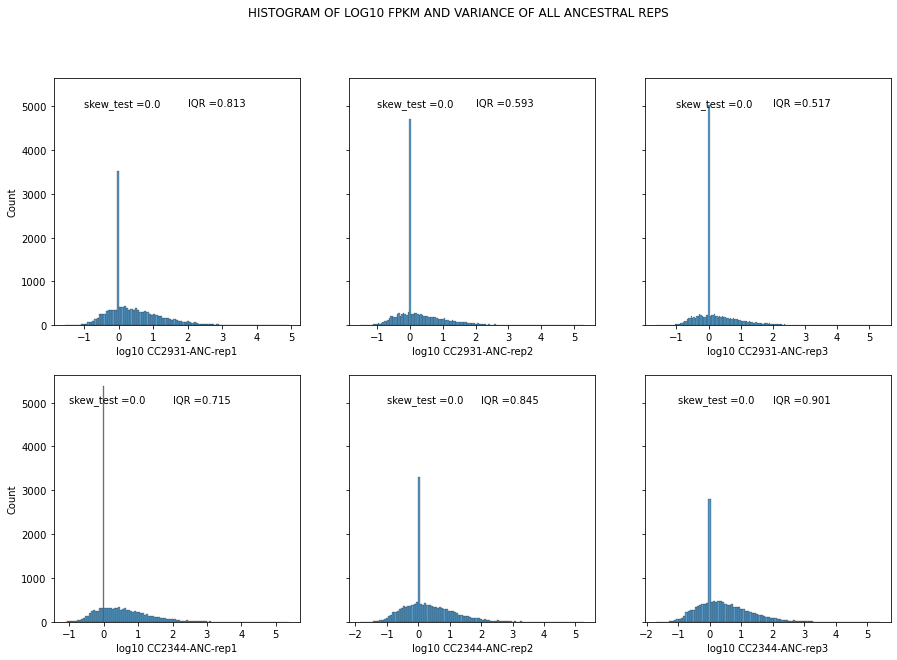

In [9]:
#### OPENING FILES ####
CC2931_FPKM = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/fpkm/CC2931_fpkm', delimiter = '\t', index_col = 'index')
CC2344_FPKM = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/fpkm/CC2344_fpkm', delimiter = '\t', index_col = 'index')

#### TAKING THE LOG10 OF VALUES AND EXCLUDING ZEROS ####
a = np.log10(CC2931_FPKM['CC2931-ANC-rep1'])
b = np.log10(CC2931_FPKM['CC2931-ANC-rep2'])
c = np.log10(CC2931_FPKM['CC2931-ANC-rep3'])
d = np.log10(CC2344_FPKM['CC2344-ANC-rep1'])
e = np.log10(CC2344_FPKM['CC2344-ANC-rep2'])
f = np.log10(CC2344_FPKM['CC2344-ANC-rep3'])

a = a.replace(np.log(0), 0) ## replace np.log(0) with 0
b = b.replace(np.log(0), 0)
c = c.replace(np.log(0), 0)
d = d.replace(np.log(0), 0)
e = e.replace(np.log(0), 0)
f = f.replace(np.log(0), 0)

fig, axes = plt.subplots(2, 3, figsize=(15, 10), sharey=True)
fig.suptitle('HISTOGRAM OF LOG10 FPKM AND VARIANCE OF ALL ANCESTRAL REPS')

ax1 = sns.histplot(ax = axes[0,0], x = a)
axes[0,0].text(-1, 5000, "skew_test =" + str(round(scipy.stats.skewtest(a)[1], 3)))
axes[0,0].text(2, 5000, "IQR =" + str(round(scipy.stats.iqr(a, rng=(25, 75)), 3)))
ax1.set_xlabel('log10 CC2931-ANC-rep1')
ax2 = sns.histplot(ax = axes[0,1], x = b)
axes[0,1].text(-1, 5000, "skew_test =" + str(round(scipy.stats.skewtest(b)[1], 3)))
axes[0,1].text(2, 5000, "IQR =" + str(round(scipy.stats.iqr(b, rng=(25, 75)), 3)))
ax2.set_xlabel('log10 CC2931-ANC-rep2')
ax3 = sns.histplot(ax = axes[0,2], x = c)
axes[0,2].text(-1, 5000, "skew_test =" + str(round(scipy.stats.skewtest(c)[1], 3)))
axes[0,2].text(2, 5000, "IQR =" + str(round(scipy.stats.iqr(c, rng=(25, 75)), 3)))
ax3.set_xlabel('log10 CC2931-ANC-rep3')
ax4 = sns.histplot(ax = axes[1,0], x = d)
axes[1,0].text(-1, 5000, "skew_test =" + str(round(scipy.stats.skewtest(d)[1], 3)))
axes[1,0].text(2, 5000, "IQR =" + str(round(scipy.stats.iqr(d, rng=(25, 75)), 3)))
ax4.set_xlabel('log10 CC2344-ANC-rep1')
ax5 = sns.histplot(ax = axes[1,1], x = e)
axes[1,1].text(-1, 5000, "skew_test =" + str(round(scipy.stats.skewtest(e)[1], 3)))
axes[1,1].text(2, 5000, "IQR =" + str(round(scipy.stats.iqr(e, rng=(25, 75)), 3)))
ax5.set_xlabel('log10 CC2344-ANC-rep2')
ax6 = sns.histplot(ax = axes[1,2], x = f)
axes[1,2].text(-1, 5000, "skew_test =" + str(round(scipy.stats.skewtest(f)[1], 3)))
axes[1,2].text(2, 5000, "IQR =" + str(round(scipy.stats.iqr(f, rng=(25, 75)), 3)))
ax6.set_xlabel('log10 CC2344-ANC-rep3')

fig.savefig('/research/projects/chlamydomonas/MAexpression/analysis/fpkm/histogram/log10_all_ancestral.pdf', format = 'pdf', dpi = 150, bbox_inches = 'tight')

/home/balogu15/.conda/envs/personal/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
<ipython-input-20-ae7918d11563>:9: RuntimeWarning: divide by zero encountered in log
  a = a.replace(np.log(0), np.nan)
<ipython-input-20-ae7918d11563>:10: RuntimeWarning: divide by zero encountered in log
  b = b.replace(np.log(0), np.nan)
<ipython-input-20-ae7918d11563>:11: RuntimeWarning: divide by zero encountered in log
  c = c.replace(np.log(0), np.nan)
<ipython-input-20-ae7918d11563>:12: RuntimeWarning: divide by zero encountered in log
  d = d.replace(np.log(0), np.nan)
<ipython-input-20-ae7918d11563>:13: RuntimeWarning: divide by zero encountered in log
  e = e.replace(np.log(0), np.nan)
<ipython-input-20-ae7918d11563>:14: RuntimeWarning: divide by zero encountered in log
  f = f.replace(np.log(0), np.nan)


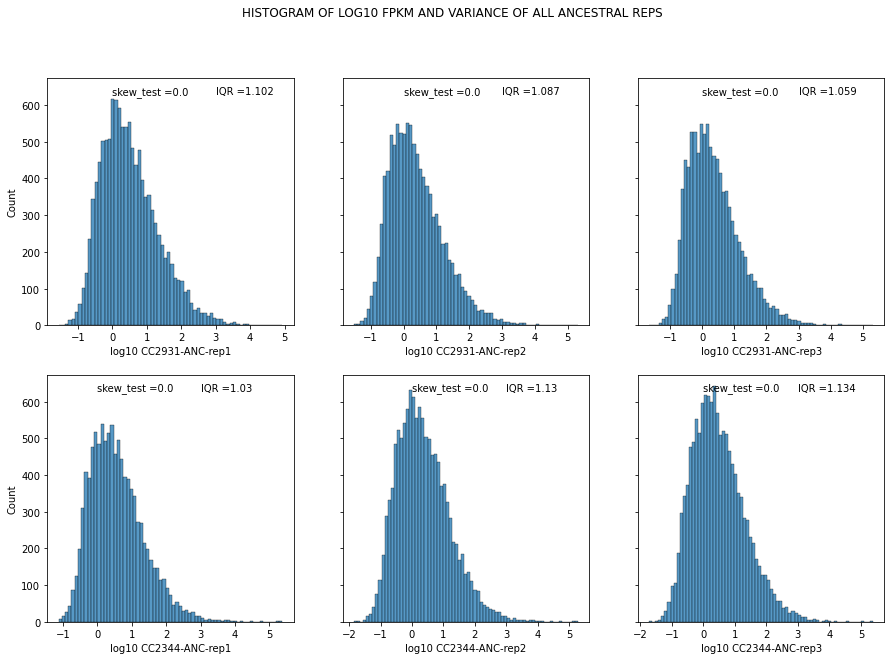

In [20]:
#### TAKING THE LOG10 OF VALUES AND EXCLUDING ZEROS ####
a = np.log10(CC2931_FPKM['CC2931-ANC-rep1'])
b = np.log10(CC2931_FPKM['CC2931-ANC-rep2'])
c = np.log10(CC2931_FPKM['CC2931-ANC-rep3'])
d = np.log10(CC2344_FPKM['CC2344-ANC-rep1'])
e = np.log10(CC2344_FPKM['CC2344-ANC-rep2'])
f = np.log10(CC2344_FPKM['CC2344-ANC-rep3'])

a = a.replace(np.log(0), np.nan)
b = b.replace(np.log(0), np.nan)
c = c.replace(np.log(0), np.nan)
d = d.replace(np.log(0), np.nan)
e = e.replace(np.log(0), np.nan)
f = f.replace(np.log(0), np.nan)

a = a.dropna()
b = b.dropna()
c = c.dropna()
d = d.dropna()
e = e.dropna()
f = f.dropna()

fig, axes = plt.subplots(2, 3, figsize=(15, 10), sharey=True)
fig.suptitle('HISTOGRAM OF LOG10 FPKM AND VARIANCE OF ALL ANCESTRAL REPS')

ax1 = sns.histplot(ax = axes[0,0], x = a)
axes[0,0].text(0, 630, "skew_test =" + str(round(scipy.stats.skewtest(a)[1], 3)))
axes[0,0].text(3, 630, "IQR =" + str(round(scipy.stats.iqr(a, rng=(25, 75)), 3)))
ax1.set_xlabel('log10 CC2931-ANC-rep1')
ax2 = sns.histplot(ax = axes[0,1], x = b)
axes[0,1].text(0, 630, "skew_test =" + str(round(scipy.stats.skewtest(b)[1], 3)))
axes[0,1].text(3, 630, "IQR =" + str(round(scipy.stats.iqr(b, rng=(25, 75)), 3)))
ax2.set_xlabel('log10 CC2931-ANC-rep2')
ax3 = sns.histplot(ax = axes[0,2], x = c)
axes[0,2].text(0, 630, "skew_test =" + str(round(scipy.stats.skewtest(c)[1], 3)))
axes[0,2].text(3, 630, "IQR =" + str(round(scipy.stats.iqr(c, rng=(25, 75)), 3)))
ax3.set_xlabel('log10 CC2931-ANC-rep3')
ax4 = sns.histplot(ax = axes[1,0], x = d)
axes[1,0].text(0, 630, "skew_test =" + str(round(scipy.stats.skewtest(d)[1], 3)))
axes[1,0].text(3, 630, "IQR =" + str(round(scipy.stats.iqr(d, rng=(25, 75)), 3)))
ax4.set_xlabel('log10 CC2344-ANC-rep1')
ax5 = sns.histplot(ax = axes[1,1], x = e)
axes[1,1].text(0, 630, "skew_test =" + str(round(scipy.stats.skewtest(e)[1], 3)))
axes[1,1].text(3, 630, "IQR =" + str(round(scipy.stats.iqr(e, rng=(25, 75)), 3)))
ax5.set_xlabel('log10 CC2344-ANC-rep2')
ax6 = sns.histplot(ax = axes[1,2], x = f)
axes[1,2].text(0, 630, "skew_test =" + str(round(scipy.stats.skewtest(f)[1], 3)))
axes[1,2].text(3, 630, "IQR =" + str(round(scipy.stats.iqr(f, rng=(25, 75)), 3)))
ax6.set_xlabel('log10 CC2344-ANC-rep3')

fig.savefig('/research/projects/chlamydomonas/MAexpression/analysis/fpkm/histogram/log10_all_ancestral_log(0)removed.pdf', format = 'pdf', dpi = 150, bbox_inches = 'tight')

### HISTOGRAM OF FPKMS + VARIANCE

/home/balogu15/.conda/envs/personal/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
<ipython-input-33-9e2d2d66617d>:8: RuntimeWarning: divide by zero encountered in log
  a = a.replace(np.log(0), 0)
/home/balogu15/.conda/envs/personal/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
<ipython-input-33-9e2d2d66617d>:8: RuntimeWarning: divide by zero encountered in log
  a = a.replace(np.log(0), 0)
/home/balogu15/.conda/envs/personal/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
<ipython-input-33-9e2d2d66617d>:8: RuntimeWarning: divide by zero encountered in log
  a = a.replace(np.log(0), 0)
/home/balogu15/.conda/envs/personal/lib/python3.8/site-pac

/home/balogu15/.conda/envs/personal/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
<ipython-input-33-9e2d2d66617d>:19: RuntimeWarning: divide by zero encountered in log
  a = a.replace(np.log(0), 0)
/home/balogu15/.conda/envs/personal/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
<ipython-input-33-9e2d2d66617d>:19: RuntimeWarning: divide by zero encountered in log
  a = a.replace(np.log(0), 0)
/home/balogu15/.conda/envs/personal/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
<ipython-input-33-9e2d2d66617d>:19: RuntimeWarning: divide by zero encountered in log
  a = a.replace(np.log(0), 0)
/home/balogu15/.conda/envs/personal/lib/python3.8/site-

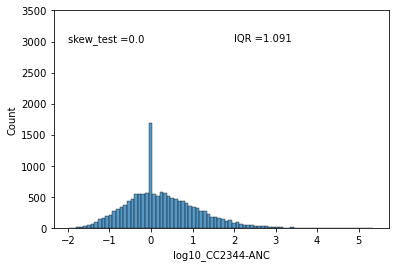

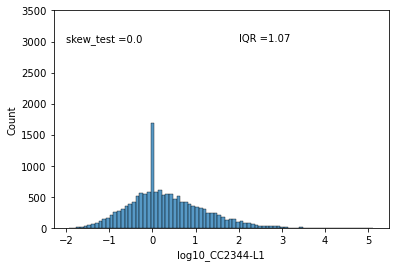

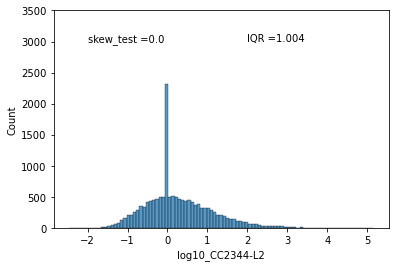

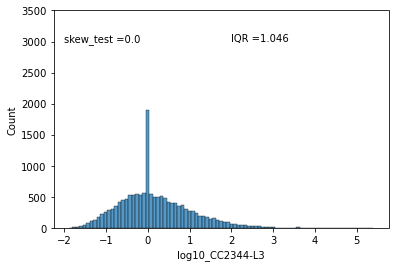

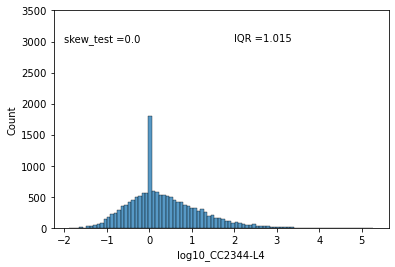

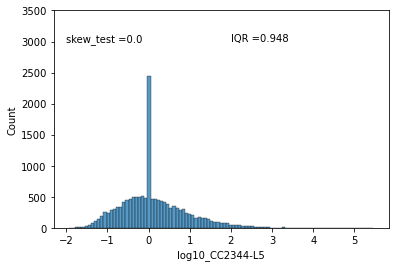

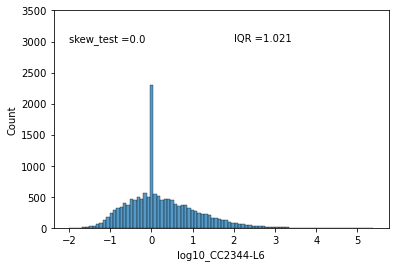

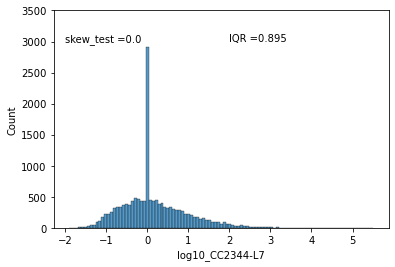

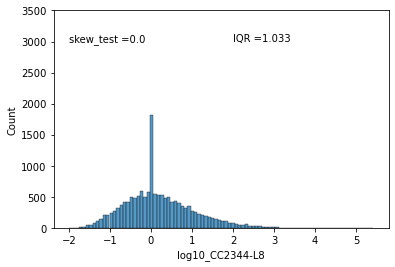

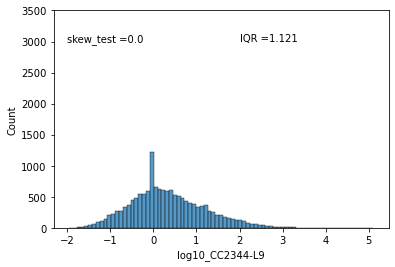

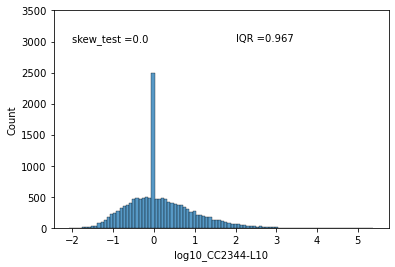

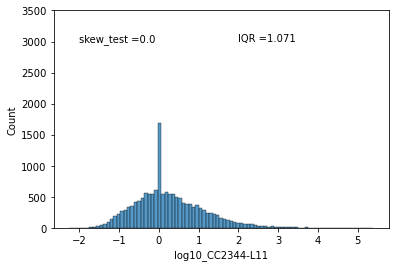

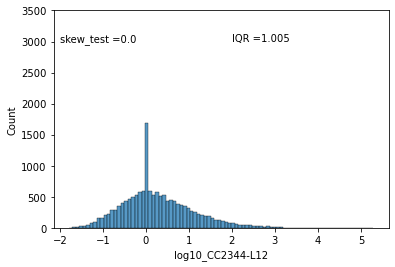

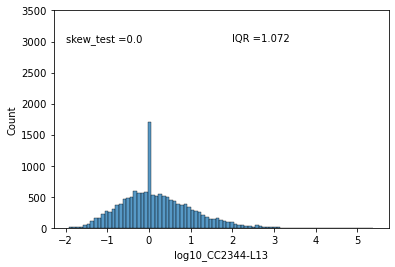

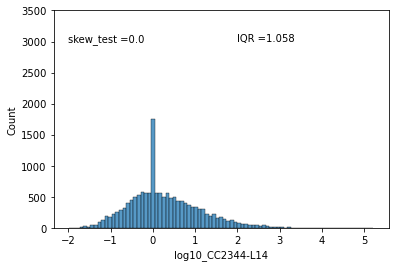

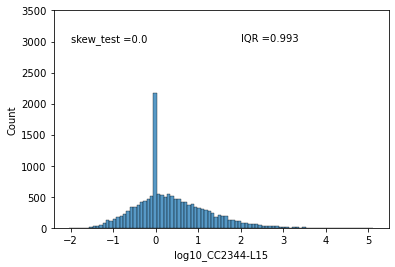

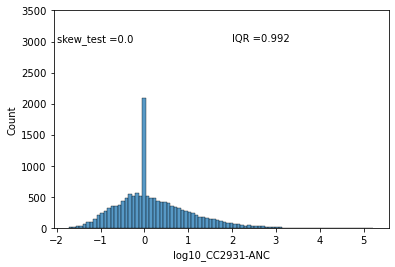

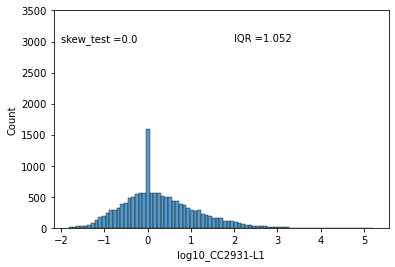

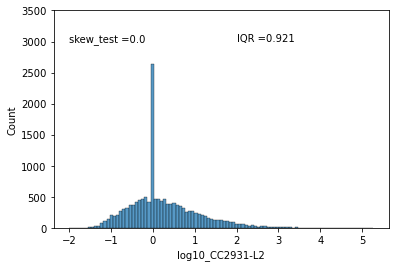

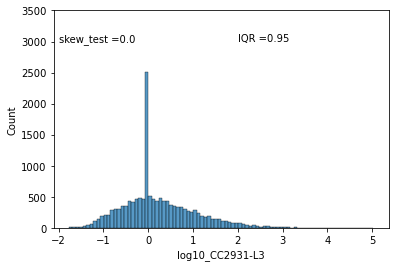

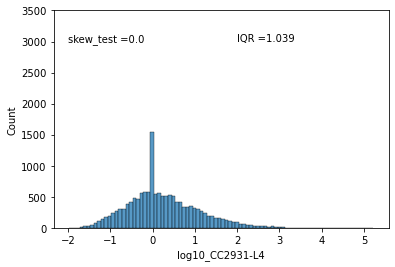

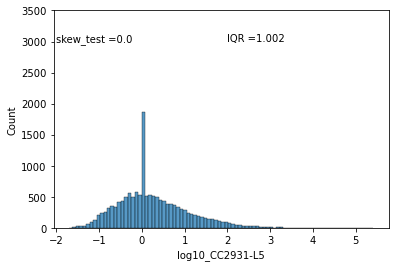

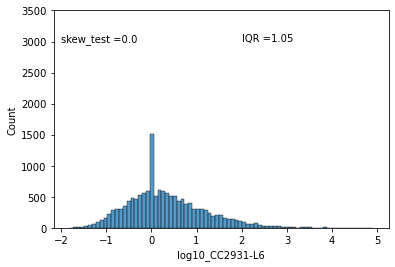

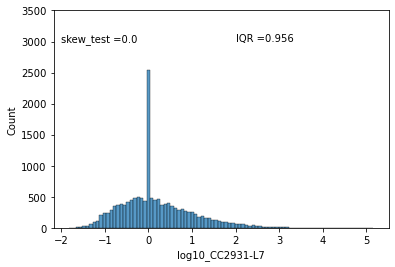

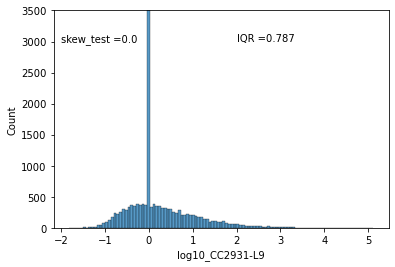

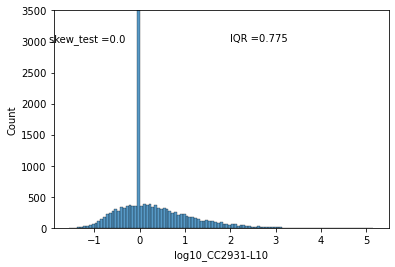

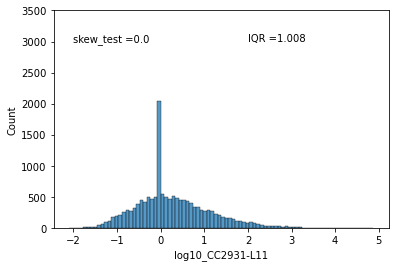

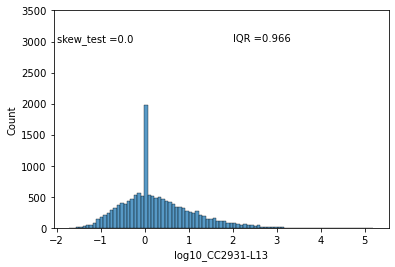

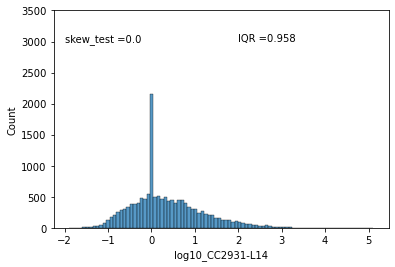

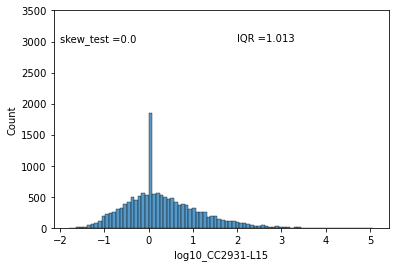

In [33]:
CC2344_fpkm = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/fpkm/CC2344_avg_fpkm', delimiter = '\t', index_col = 'index')
CC2931_fpkm = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/fpkm/CC2931_avg_fpkm', delimiter = '\t', index_col = 'index')

#### TESTING FOR SKEWNESS BASED ON PEARSON'S SKEWNESS INDEX ####
for i in CC2344_fpkm.columns:
    plt.figure()
    a = np.log10(CC2344_fpkm[i])
    a = a.replace(np.log(0), 0)
    sns.histplot(a)
    plt.text(-2, 3000, "skew_test =" + str(round(scipy.stats.skewtest(a)[1], 3)))
    plt.text(2, 3000, "IQR =" + str(round(scipy.stats.iqr(a, rng=(25, 75)), 3)))
    plt.xlabel('log10_' + i)
    plt.ylim(0, 3500)
    plt.savefig('/research/projects/chlamydomonas/MAexpression/analysis/fpkm/histogram/log10_' + i + '.pdf', format = 'pdf', dpi = 150, bbox_inches = 'tight')
    
for i in CC2931_fpkm.columns:
    plt.figure()
    a = np.log10(CC2931_fpkm[i])
    a = a.replace(np.log(0), 0)
    sns.histplot(a)
    plt.text(-2, 3000, "skew_test =" + str(round(scipy.stats.skewtest(a)[1], 3)))
    plt.text(2, 3000, "IQR =" + str(round(scipy.stats.iqr(a, rng=(25, 75)), 3)))
    plt.xlabel('log10_' + i)
    plt.ylim(0, 3500)
    plt.savefig('/research/projects/chlamydomonas/MAexpression/analysis/fpkm/histogram/log10_' + i + '.pdf', format = 'pdf', dpi = 150, bbox_inches = 'tight')
    
#### ZOOMED IN - TESTING FOR SKEWNESS BASED ON PEARSON'S SKEWNESS INDEX ####
for i in CC2344_fpkm.columns:
    plt.figure()
    a = np.log10(CC2344_fpkm[i])
    a = a.replace(np.log(0), 0)
    sns.histplot(a)
    plt.text(-2, 900, "skew_test =" + str(round(scipy.stats.skewtest(a)[1], 3)))
    plt.text(2, 900, "IQR =" + str(round(scipy.stats.iqr(a, rng=(25, 75)), 3)))
    plt.xlabel('log10_' + i)
    plt.ylim(0, 1000)
    plt.savefig('/research/projects/chlamydomonas/MAexpression/analysis/fpkm/histogram/zoomin_log10_' + i + '.pdf', format = 'pdf', dpi = 150, bbox_inches = 'tight')
    
for i in CC2931_fpkm.columns:
    plt.figure()
    a = np.log10(CC2931_fpkm[i])
    a = a.replace(np.log(0), 0)
    sns.histplot(a)
    plt.text(-2, 900, "skew_test =" + str(round(scipy.stats.skewtest(a)[1], 3)))
    plt.text(2, 900, "IQR =" + str(round(scipy.stats.iqr(a, rng=(25, 75)), 3)))
    plt.xlabel('log10_' + i)
    plt.ylim(0, 1000)
    plt.xlim(-2, 5)
    plt.savefig('/research/projects/chlamydomonas/MAexpression/analysis/fpkm/histogram/zoomin_log10_' + i + '.pdf', format = 'pdf', dpi = 150, bbox_inches = 'tight')

/home/balogu15/.conda/envs/personal/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
<ipython-input-22-8b7762f0e8b7>:8: RuntimeWarning: divide by zero encountered in log
  a = a.replace(np.log(0), np.nan)
/home/balogu15/.conda/envs/personal/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
<ipython-input-22-8b7762f0e8b7>:8: RuntimeWarning: divide by zero encountered in log
  a = a.replace(np.log(0), np.nan)
/home/balogu15/.conda/envs/personal/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
<ipython-input-22-8b7762f0e8b7>:8: RuntimeWarning: divide by zero encountered in log
  a = a.replace(np.log(0), np.nan)
/home/balogu15/.conda/envs/personal/lib/pyt

/home/balogu15/.conda/envs/personal/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
<ipython-input-22-8b7762f0e8b7>:20: RuntimeWarning: divide by zero encountered in log
  a = a.replace(np.log(0), np.nan)
/home/balogu15/.conda/envs/personal/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
<ipython-input-22-8b7762f0e8b7>:20: RuntimeWarning: divide by zero encountered in log
  a = a.replace(np.log(0), np.nan)
/home/balogu15/.conda/envs/personal/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
<ipython-input-22-8b7762f0e8b7>:20: RuntimeWarning: divide by zero encountered in log
  a = a.replace(np.log(0), np.nan)
/home/balogu15/.conda/envs/personal/lib/

/home/balogu15/.conda/envs/personal/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
<ipython-input-22-8b7762f0e8b7>:45: RuntimeWarning: divide by zero encountered in log
  a = a.replace(np.log(0), np.nan)
/home/balogu15/.conda/envs/personal/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
<ipython-input-22-8b7762f0e8b7>:45: RuntimeWarning: divide by zero encountered in log
  a = a.replace(np.log(0), np.nan)
/home/balogu15/.conda/envs/personal/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
<ipython-input-22-8b7762f0e8b7>:45: RuntimeWarning: divide by zero encountered in log
  a = a.replace(np.log(0), np.nan)
/home/balogu15/.conda/envs/personal/lib/

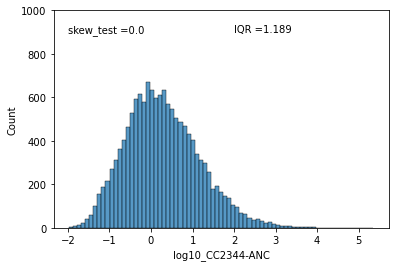

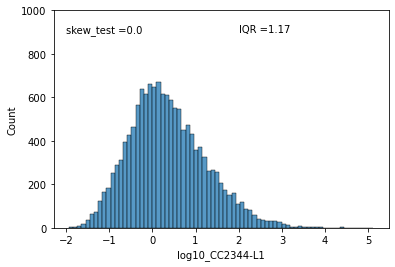

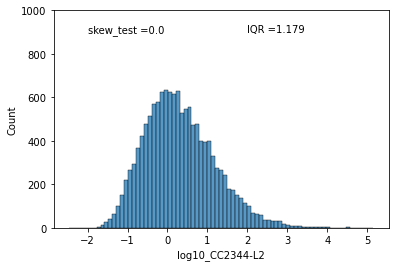

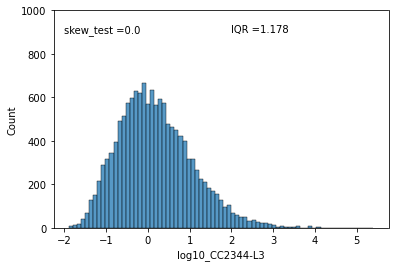

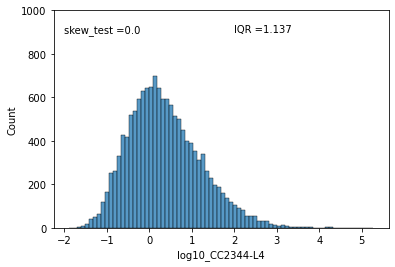

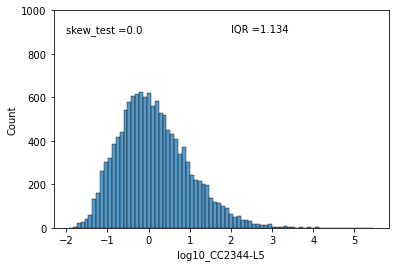

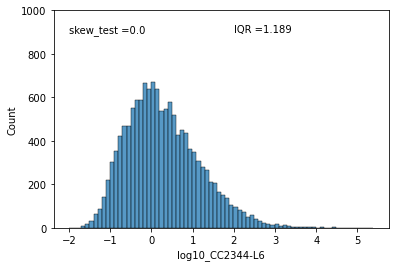

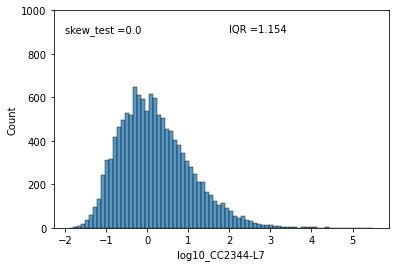

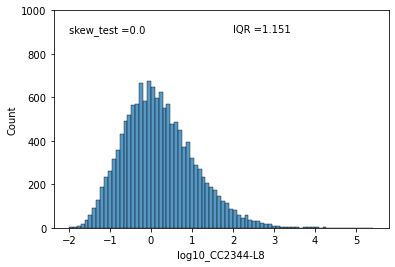

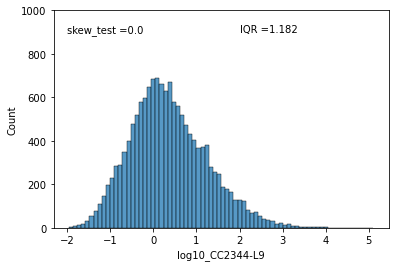

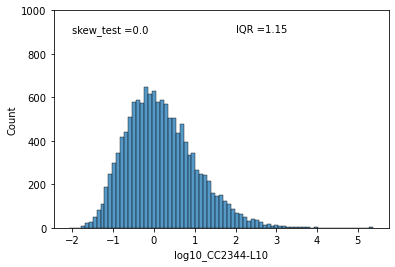

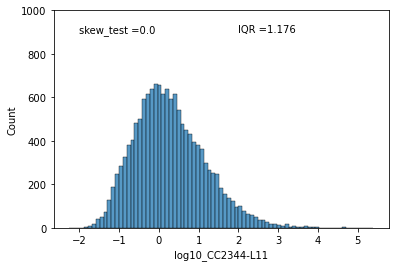

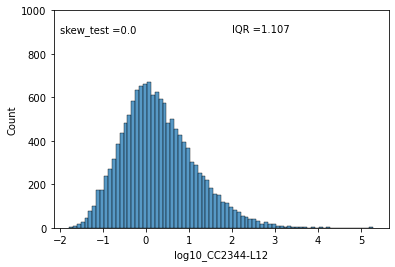

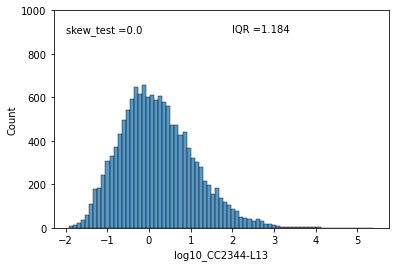

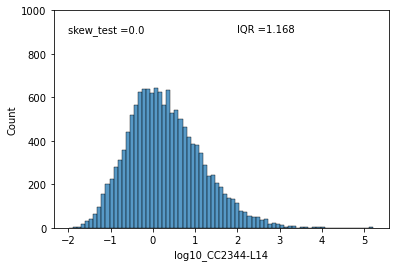

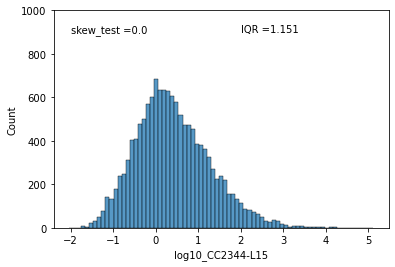

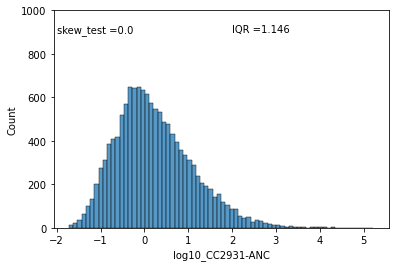

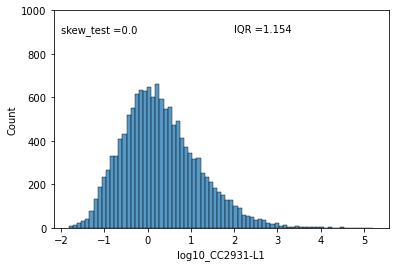

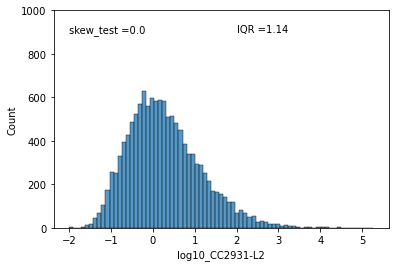

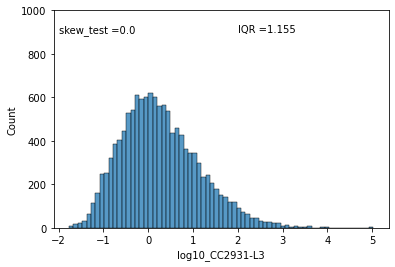

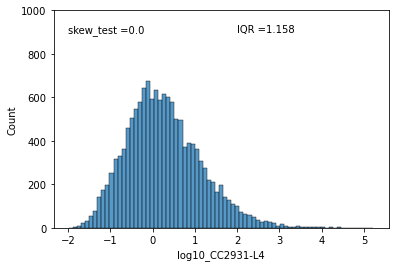

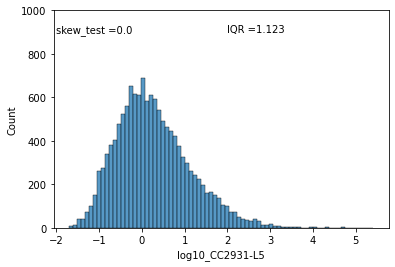

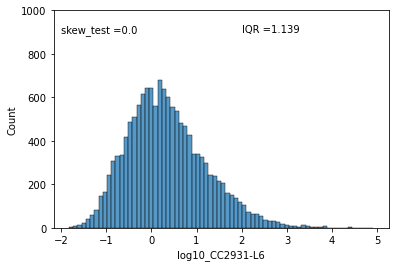

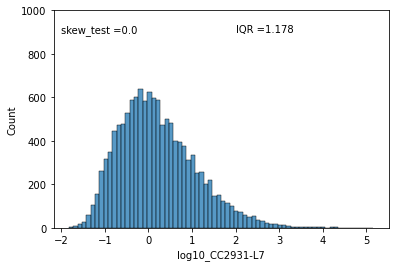

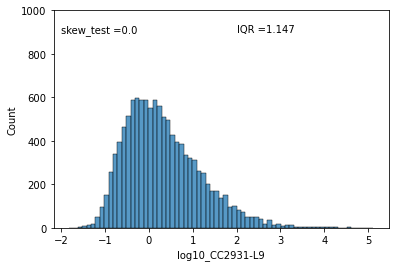

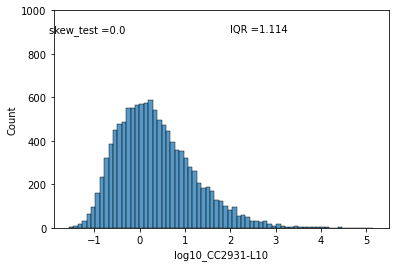

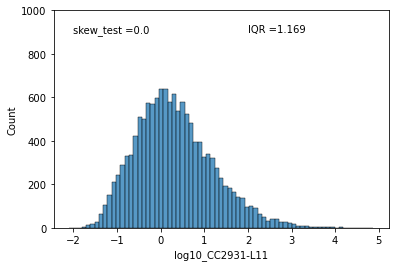

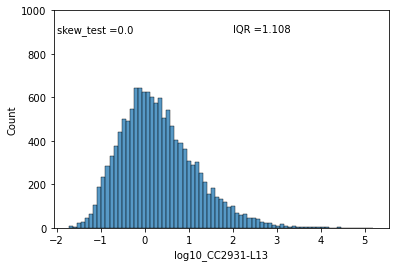

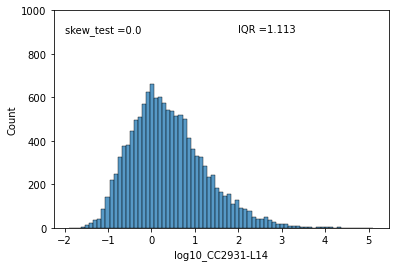

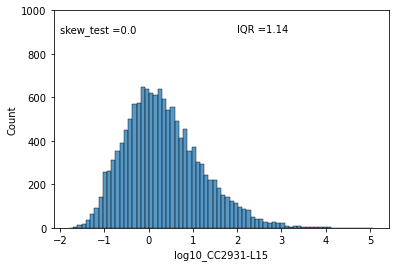

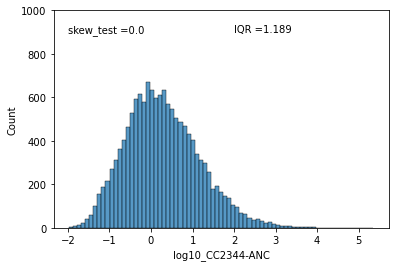

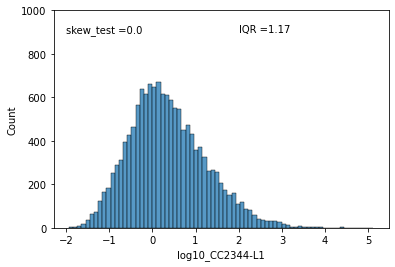

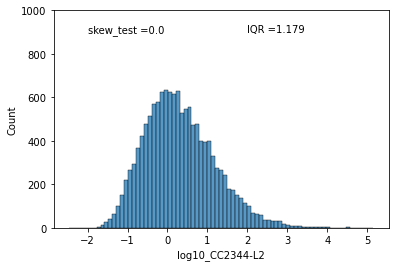

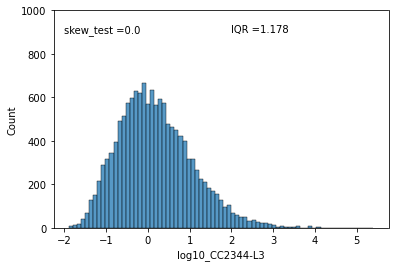

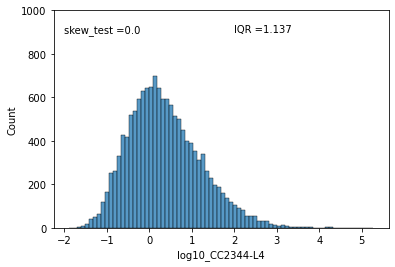

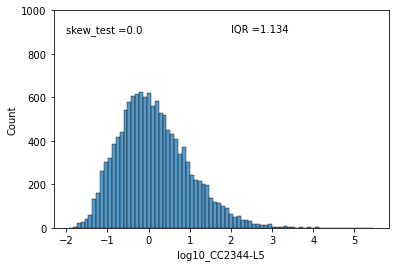

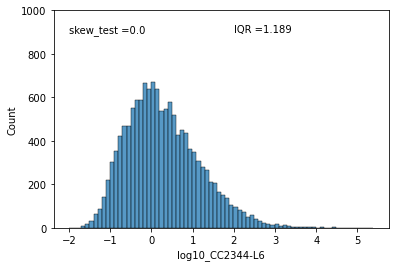

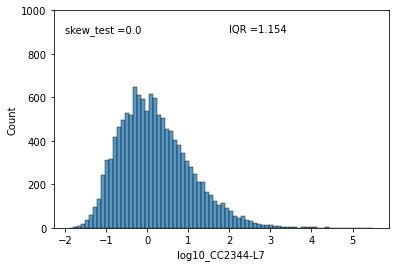

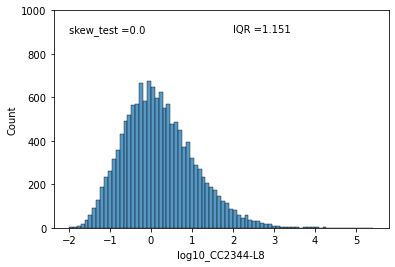

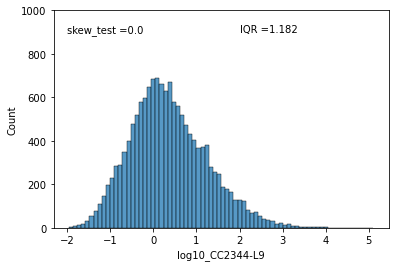

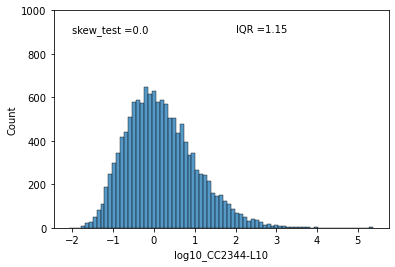

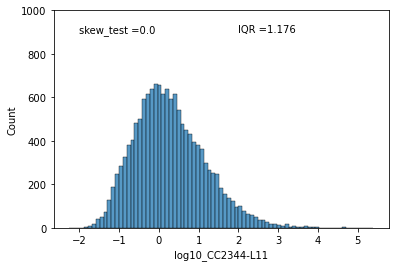

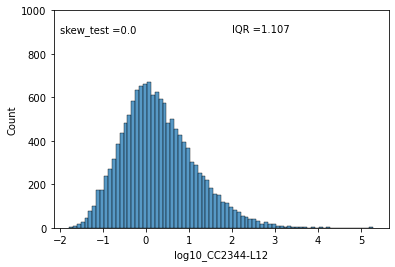

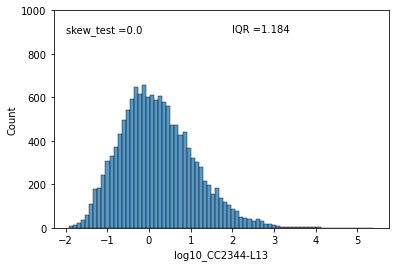

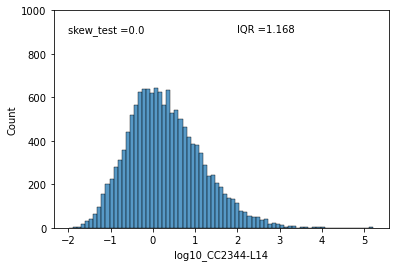

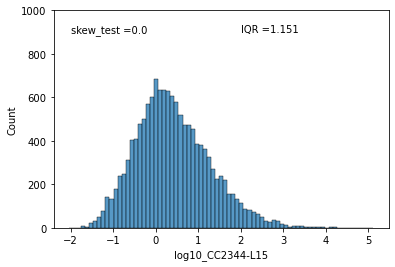

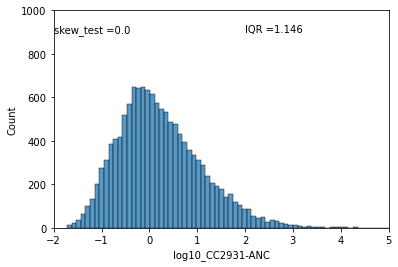

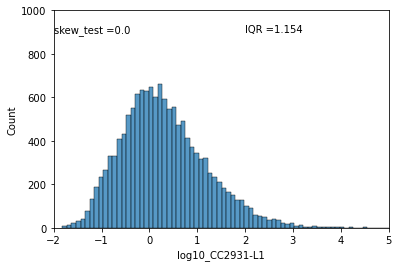

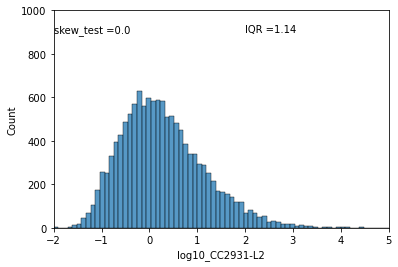

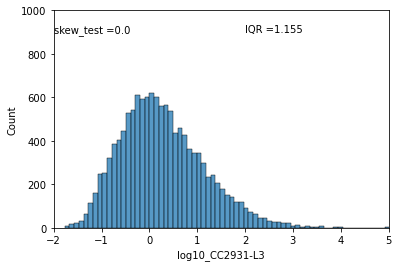

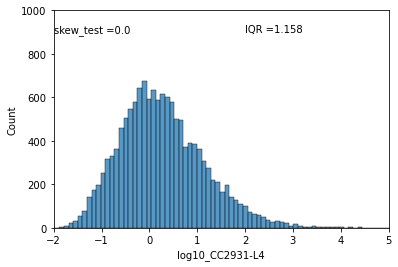

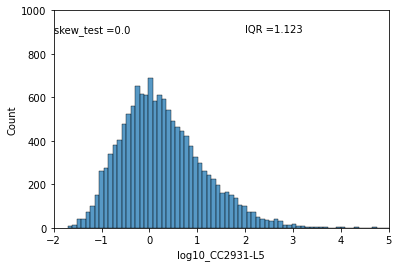

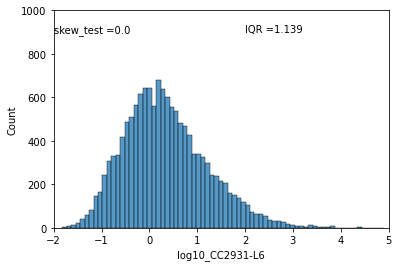

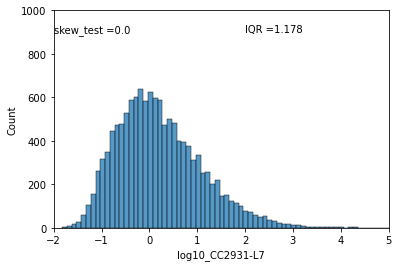

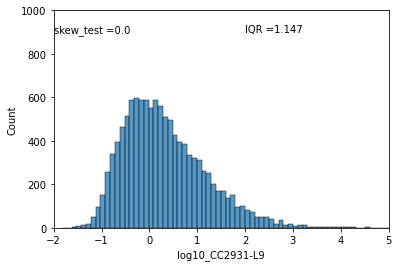

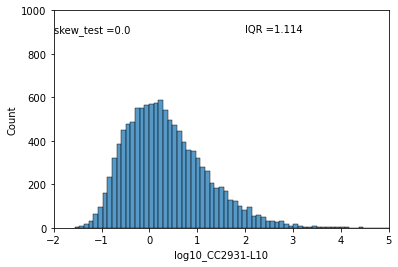

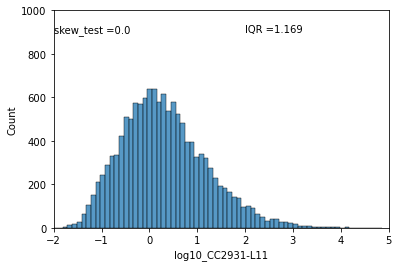

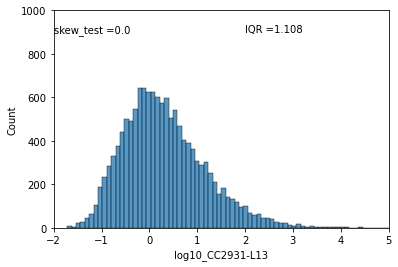

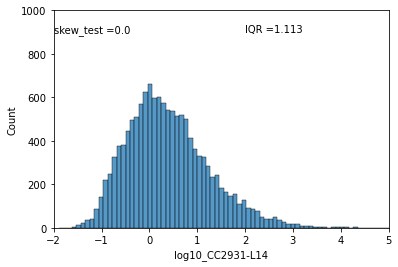

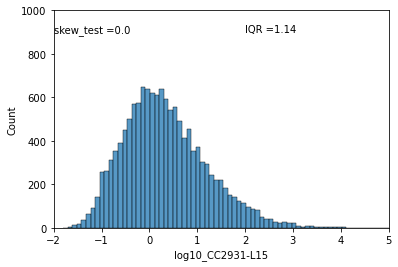

In [22]:
CC2344_fpkm = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/fpkm/CC2344_avg_fpkm', delimiter = '\t', index_col = 'index')
CC2931_fpkm = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/fpkm/CC2931_avg_fpkm', delimiter = '\t', index_col = 'index')

#### TESTING FOR SKEWNESS BASED ON PEARSON'S SKEWNESS INDEX ####
for i in CC2344_fpkm.columns:
    plt.figure()
    a = np.log10(CC2344_fpkm[i])
    a = a.replace(np.log(0), np.nan)
    a = a.dropna()
    sns.histplot(a)
    plt.text(-2, 900, "skew_test =" + str(round(scipy.stats.skewtest(a)[1], 3)))
    plt.text(2, 900, "IQR =" + str(round(scipy.stats.iqr(a, rng=(25, 75)), 3)))
    plt.xlabel('log10_' + i)
    plt.ylim(0, 1000)
    plt.savefig('/research/projects/chlamydomonas/MAexpression/analysis/fpkm/histogram/log10_' + i + '_log(0)removed.pdf', format = 'pdf', dpi = 150, bbox_inches = 'tight')
    
for i in CC2931_fpkm.columns:
    plt.figure()
    a = np.log10(CC2931_fpkm[i])
    a = a.replace(np.log(0), np.nan)
    a = a.dropna()
    sns.histplot(a)
    plt.text(-2, 900, "skew_test =" + str(round(scipy.stats.skewtest(a)[1], 3)))
    plt.text(2, 900, "IQR =" + str(round(scipy.stats.iqr(a, rng=(25, 75)), 3)))
    plt.xlabel('log10_' + i)
    plt.ylim(0, 1000)
    plt.savefig('/research/projects/chlamydomonas/MAexpression/analysis/fpkm/histogram/log10_' + i + '_log(0)removed.pdf', format = 'pdf', dpi = 150, bbox_inches = 'tight')
    
#### ZOOMED IN - TESTING FOR SKEWNESS BASED ON PEARSON'S SKEWNESS INDEX ####
for i in CC2344_fpkm.columns:
    plt.figure()
    a = np.log10(CC2344_fpkm[i])
    a = a.replace(np.log(0), np.nan)
    a = a.dropna()
    sns.histplot(a)
    plt.text(-2, 900, "skew_test =" + str(round(scipy.stats.skewtest(a)[1], 3)))
    plt.text(2, 900, "IQR =" + str(round(scipy.stats.iqr(a, rng=(25, 75)), 3)))
    plt.xlabel('log10_' + i)
    plt.ylim(0, 1000)
    plt.savefig('/research/projects/chlamydomonas/MAexpression/analysis/fpkm/histogram/zoomin_log10_' + i + '_log(0)removed.pdf', format = 'pdf', dpi = 150, bbox_inches = 'tight')
    
for i in CC2931_fpkm.columns:
    plt.figure()
    a = np.log10(CC2931_fpkm[i])
    a = a.replace(np.log(0), np.nan)
    a = a.dropna()
    sns.histplot(a)
    plt.text(-2, 900, "skew_test =" + str(round(scipy.stats.skewtest(a)[1], 3)))
    plt.text(2, 900, "IQR =" + str(round(scipy.stats.iqr(a, rng=(25, 75)), 3)))
    plt.xlabel('log10_' + i)
    plt.ylim(0, 1000)
    plt.xlim(-2, 5)
    plt.savefig('/research/projects/chlamydomonas/MAexpression/analysis/fpkm/histogram/zoomin_log10_' + i + '_log(0)removed.pdf', format = 'pdf', dpi = 150, bbox_inches = 'tight')

### IDENTIFYING HIGH AND LOW EXPRESSION GENES BASED ON FPKM

In [54]:
#### OPENING FILES ####
CC2344_avg_fpkm = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/fpkm/CC2344_avg_fpkm', delimiter = '\t')
CC2931_avg_fpkm = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/fpkm/CC2931_avg_fpkm', delimiter = '\t')

#### 10TH PERCENTILE - LOW EXPRESSION GENES ####
CC2931_ANC_10 = np.percentile(CC2931_avg_fpkm['CC2931-ANC'], 10)
CC2344_ANC_10 = np.percentile(CC2344_avg_fpkm['CC2344-ANC'], 10)

section = CC2931_avg_fpkm.loc[CC2931_avg_fpkm['CC2931-ANC'] <= CC2931_ANC_10]
CC2931_LEGs = section['index'].values.tolist()
section = CC2344_avg_fpkm.loc[CC2344_avg_fpkm['CC2344-ANC'] <= CC2344_ANC_10]
CC2344_LEGs = section['index'].values.tolist()

#### 90TH PERCENTILE - HIGH EXPRESSION GENES ####
CC2931_ANC_90 = np.percentile(CC2931_avg_fpkm['CC2931-ANC'], 90)
CC2344_ANC_90 = np.percentile(CC2344_avg_fpkm['CC2344-ANC'], 90)

section = CC2931_avg_fpkm.loc[CC2931_avg_fpkm['CC2931-ANC'] >= CC2931_ANC_90]
CC2931_HEGs = section['index'].values.tolist()
section = CC2344_avg_fpkm.loc[CC2344_avg_fpkm['CC2344-ANC'] >= CC2344_ANC_90]
CC2344_HEGs = section['index'].values.tolist()
    
#### CHECKING FOR OVERLAPS IN HIGH/LOW EXPRESSION GENES ACROSS GENOTYPES ####
HEG_overlap = list(set.intersection(set(CC2344_HEGs), set(CC2931_HEGs)))
HEG_percent_overlap = len(HEG_overlap)/len(CC2931_HEGs)
saved_list = pd.Series(HEG_overlap, name = 'HEG').to_csv('/research/projects/chlamydomonas/MAexpression/analysis/fpkm/HEGs_list.csv', sep = '\t', header = True)
LEG_overlap = list(set.intersection(set(CC2344_LEGs), set(CC2931_LEGs)))
LEG_percent_overlap = len(LEG_overlap)/len(CC2344_LEGs)
saved_list = pd.Series(LEG_overlap, name = 'LEG').to_csv('/research/projects/chlamydomonas/MAexpression/analysis/fpkm/LEGs_list.csv', sep = '\t', header = True)

### DISTRIBUTION OF FPKM ACROSS GENES

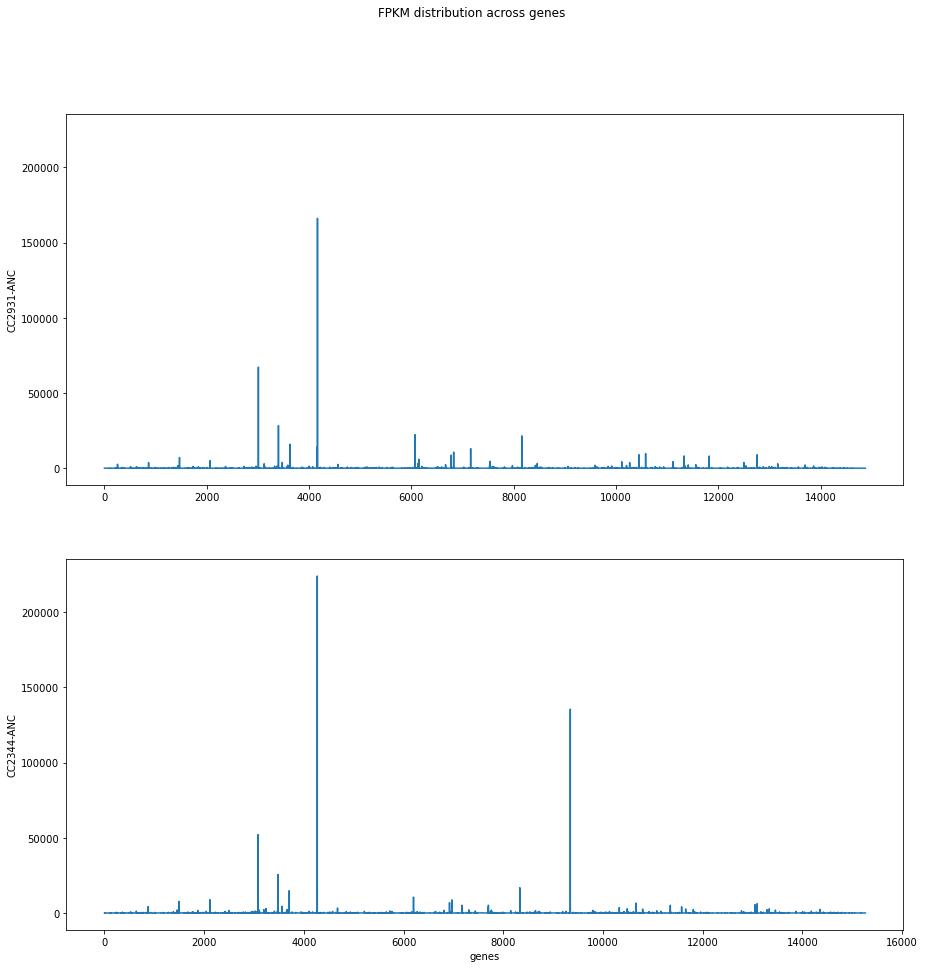

<Figure size 432x288 with 0 Axes>

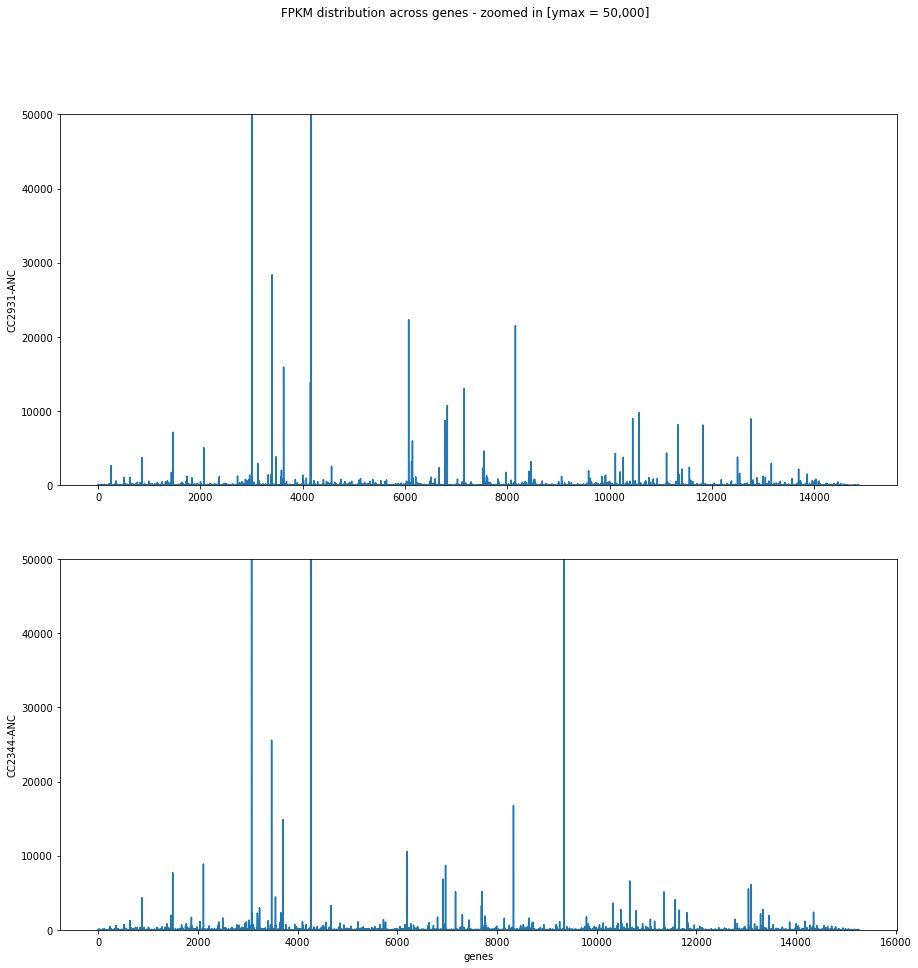

<Figure size 432x288 with 0 Axes>

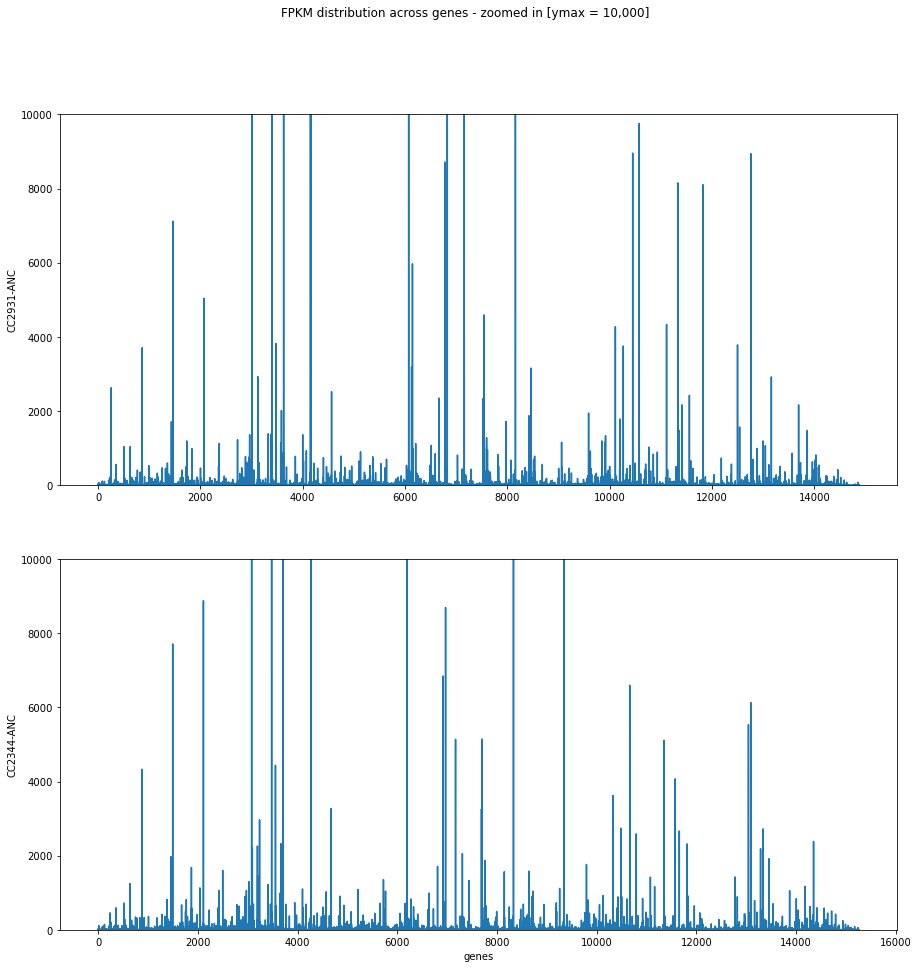

In [57]:
## LIST OF GENES
CC2344 = ['CC2344-ANC', "CC2344-L1", "CC2344-L2", "CC2344-L3", "CC2344-L4", "CC2344-L5", "CC2344-L6", "CC2344-L7", "CC2344-L8", "CC2344-L9", "CC2344-L10", "CC2344-L11", "CC2344-L12", "CC2344-L13", "CC2344-L14", "CC2344-L15"]
CC2931 = ["CC2931-ANC", "CC2931-L1", "CC2931-L2", "CC2931-L3", "CC2931-L4", "CC2931-L5", "CC2931-L6", "CC2931-L7", "CC2931-L9", "CC2931-L10", "CC2931-L11", "CC2931-L13", "CC2931-L14", "CC2931-L15"]

## OPENING FILES
CC2931_avg_fpkm = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/fpkm/CC2931_avg_fpkm', delimiter = '\t')
CC2344_avg_fpkm = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/fpkm/CC2344_avg_fpkm', delimiter = '\t')

fig, axes = plt.subplots(2, 1, figsize=(15, 15), sharey=True)
fig.suptitle('FPKM distribution across genes')

sns.lineplot(ax = axes[0], data = CC2931_avg_fpkm, x = [i for i in range(len(CC2931_avg_fpkm))], y = 'CC2931-ANC')
sns.lineplot(ax = axes[1], data = CC2344_avg_fpkm, x = [i for i in range(len(CC2344_avg_fpkm))], y = 'CC2344-ANC')
plt.xlabel('genes')
plt.savefig('/research/projects/chlamydomonas/MAexpression/analysis/fpkm/fpkm_distribution.pdf', format = 'pdf', dpi = 150, bbox_inches = 'tight')

plt.figure()
fig, axes = plt.subplots(2, 1, figsize=(15, 15), sharey=True)
fig.suptitle('FPKM distribution across genes - zoomed in [ymax = 50,000]')

sns.lineplot(ax = axes[0], data = CC2931_avg_fpkm, x = [i for i in range(len(CC2931_avg_fpkm))], y = 'CC2931-ANC')
plt.ylim(0, 50000)
sns.lineplot(ax = axes[1], data = CC2344_avg_fpkm, x = [i for i in range(len(CC2344_avg_fpkm))], y = 'CC2344-ANC')
plt.ylim(0, 50000)
plt.xlabel('genes')
plt.savefig('/research/projects/chlamydomonas/MAexpression/analysis/fpkm/fpkm_distribution_zoomin.pdf', format = 'pdf', dpi = 150, bbox_inches = 'tight')

plt.figure()
fig, axes = plt.subplots(2, 1, figsize=(15, 15), sharey=True)
fig.suptitle('FPKM distribution across genes - zoomed in [ymax = 10,000]')

sns.lineplot(ax = axes[0], data = CC2931_avg_fpkm, x = [i for i in range(len(CC2931_avg_fpkm))], y = 'CC2931-ANC')
plt.ylim(0, 10000)
sns.lineplot(ax = axes[1], data = CC2344_avg_fpkm, x = [i for i in range(len(CC2344_avg_fpkm))], y = 'CC2344-ANC')
plt.ylim(0, 10000)
plt.xlabel('genes')
plt.savefig('/research/projects/chlamydomonas/MAexpression/analysis/fpkm/fpkm_distribution_zoomin_2.pdf', format = 'pdf', dpi = 150, bbox_inches = 'tight')

### FPKM BINS

In [2]:
CC2931_avg_fpkm = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/fpkm/CC2931_avg_fpkm', delimiter = '\t')
CC2344_avg_fpkm = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/fpkm/CC2344_avg_fpkm', delimiter = '\t')

###########################################
## CC2931 - FPKM PERCENTILE DISTRIBUTION ##
###########################################
percentile_10 = np.percentile(CC2931_avg_fpkm['CC2931-ANC'], 10)
percentile_20 = np.percentile(CC2931_avg_fpkm['CC2931-ANC'], 20)
percentile_30 = np.percentile(CC2931_avg_fpkm['CC2931-ANC'], 30)
percentile_40 = np.percentile(CC2931_avg_fpkm['CC2931-ANC'], 40)
percentile_50 = np.percentile(CC2931_avg_fpkm['CC2931-ANC'], 50)
percentile_60 = np.percentile(CC2931_avg_fpkm['CC2931-ANC'], 60)
percentile_70 = np.percentile(CC2931_avg_fpkm['CC2931-ANC'], 70)
percentile_80 = np.percentile(CC2931_avg_fpkm['CC2931-ANC'], 80)
percentile_90 = np.percentile(CC2931_avg_fpkm['CC2931-ANC'], 90)

CC2931_bins = {}
sec_10 = CC2931_avg_fpkm.loc[CC2931_avg_fpkm['CC2931-ANC'] <= percentile_10]
CC2931_bins['perc_10'] = sec_10['index'].values.tolist()
sec_20 = CC2931_avg_fpkm.loc[(percentile_10 < CC2931_avg_fpkm['CC2931-ANC']) & (CC2931_avg_fpkm['CC2931-ANC'] <= percentile_20)]
CC2931_bins['perc_20'] = sec_20['index'].values.tolist()
sec_30 = CC2931_avg_fpkm.loc[(percentile_20 < CC2931_avg_fpkm['CC2931-ANC']) & (CC2931_avg_fpkm['CC2931-ANC'] <= percentile_30)]
CC2931_bins['perc_30'] = sec_30['index'].values.tolist()
sec_40 = CC2931_avg_fpkm.loc[(percentile_30 < CC2931_avg_fpkm['CC2931-ANC']) & (CC2931_avg_fpkm['CC2931-ANC'] <= percentile_40)]
CC2931_bins['perc_40'] = sec_40['index'].values.tolist()
sec_50 = CC2931_avg_fpkm.loc[(percentile_40 < CC2931_avg_fpkm['CC2931-ANC']) & (CC2931_avg_fpkm['CC2931-ANC'] <= percentile_50)]
CC2931_bins['perc_50'] = sec_50['index'].values.tolist()
sec_60 = CC2931_avg_fpkm.loc[(percentile_50 < CC2931_avg_fpkm['CC2931-ANC']) & (CC2931_avg_fpkm['CC2931-ANC'] <= percentile_60)]
CC2931_bins['perc_60'] = sec_60['index'].values.tolist()
sec_70 = CC2931_avg_fpkm.loc[(percentile_60 < CC2931_avg_fpkm['CC2931-ANC']) & (CC2931_avg_fpkm['CC2931-ANC'] <= percentile_70)]
CC2931_bins['perc_70'] = sec_70['index'].values.tolist()
sec_80 = CC2931_avg_fpkm.loc[(percentile_70 < CC2931_avg_fpkm['CC2931-ANC']) & (CC2931_avg_fpkm['CC2931-ANC'] <= percentile_80)]
CC2931_bins['perc_80'] = sec_80['index'].values.tolist()
sec_90 = CC2931_avg_fpkm.loc[(percentile_80 < CC2931_avg_fpkm['CC2931-ANC']) & (CC2931_avg_fpkm['CC2931-ANC'] <= percentile_90)]
CC2931_bins['perc_90'] = sec_90['index'].values.tolist()

###########################################
## CC2344 - FPKM PERCENTILE DISTRIBUTION ##
###########################################
percentile_10 = np.percentile(CC2344_avg_fpkm['CC2344-ANC'], 10)
percentile_20 = np.percentile(CC2344_avg_fpkm['CC2344-ANC'], 20)
percentile_30 = np.percentile(CC2344_avg_fpkm['CC2344-ANC'], 30)
percentile_40 = np.percentile(CC2344_avg_fpkm['CC2344-ANC'], 40)
percentile_50 = np.percentile(CC2344_avg_fpkm['CC2344-ANC'], 50)
percentile_60 = np.percentile(CC2344_avg_fpkm['CC2344-ANC'], 60)
percentile_70 = np.percentile(CC2344_avg_fpkm['CC2344-ANC'], 70)
percentile_80 = np.percentile(CC2344_avg_fpkm['CC2344-ANC'], 80)
percentile_90 = np.percentile(CC2344_avg_fpkm['CC2344-ANC'], 90)

CC2344_bins = {}
sec_10 = CC2344_avg_fpkm.loc[CC2344_avg_fpkm['CC2344-ANC'] <= percentile_10]
CC2344_bins['perc_10'] = sec_10['index'].values.tolist()
sec_20 = CC2344_avg_fpkm.loc[(percentile_10 < CC2344_avg_fpkm['CC2344-ANC']) & (CC2344_avg_fpkm['CC2344-ANC'] <= percentile_20)]
CC2344_bins['perc_20'] = sec_20['index'].values.tolist()
sec_30 = CC2344_avg_fpkm.loc[(percentile_20 < CC2344_avg_fpkm['CC2344-ANC']) & (CC2344_avg_fpkm['CC2344-ANC'] <= percentile_30)]
CC2344_bins['perc_30'] = sec_30['index'].values.tolist()
sec_40 = CC2344_avg_fpkm.loc[(percentile_30 < CC2344_avg_fpkm['CC2344-ANC']) & (CC2344_avg_fpkm['CC2344-ANC'] <= percentile_40)]
CC2344_bins['perc_40'] = sec_40['index'].values.tolist()
sec_50 = CC2344_avg_fpkm.loc[(percentile_40 < CC2344_avg_fpkm['CC2344-ANC']) & (CC2344_avg_fpkm['CC2344-ANC'] <= percentile_50)]
CC2344_bins['perc_50'] = sec_50['index'].values.tolist()
sec_60 = CC2344_avg_fpkm.loc[(percentile_50 < CC2344_avg_fpkm['CC2344-ANC']) & (CC2344_avg_fpkm['CC2344-ANC'] <= percentile_60)]
CC2344_bins['perc_60'] = sec_60['index'].values.tolist()
sec_70 = CC2344_avg_fpkm.loc[(percentile_60 < CC2344_avg_fpkm['CC2344-ANC']) & (CC2344_avg_fpkm['CC2344-ANC'] <= percentile_70)]
CC2344_bins['perc_70'] = sec_70['index'].values.tolist()
sec_80 = CC2344_avg_fpkm.loc[(percentile_70 < CC2344_avg_fpkm['CC2344-ANC']) & (CC2344_avg_fpkm['CC2344-ANC'] <= percentile_80)]
CC2344_bins['perc_80'] = sec_80['index'].values.tolist()
sec_90 = CC2344_avg_fpkm.loc[(percentile_80 < CC2344_avg_fpkm['CC2344-ANC']) & (CC2344_avg_fpkm['CC2344-ANC'] <= percentile_90)]
CC2344_bins['perc_90'] = sec_90['index'].values.tolist()

### THE SUM OF LOG2FOLD CHANGE AMONG FPKM BINS

,CC2344_pval,CC2344_P,CC2931_pval,CC2931_P
perc_10-perc_20,5.143422e-35,Reject,1.939962e-44,Reject
perc_20-perc_30,1.974603e-01,Fail to Reject,4.878285e-01,Fail to Reject
perc_30-perc_40,2.277914e-09,Reject,4.236006e-01,Fail to Reject
perc_40-perc_50,1.554939e-04,Reject,1.109265e-04,Reject
perc_50-perc_60,3.139699e-03,Reject,2.155742e-08,Reject
perc_60-perc_70,3.195617e-02,Reject,1.198977e-04,Reject
perc_70-perc_80,9.179677e-02,Fail to Reject,1.119579e-04,Reject
perc_80-perc_90,1.550838e-05,Reject,4.907224e-03,Reject


,CC2344_pval,CC2344_P,CC2931_pval,CC2931_P
perc_10-perc_20,0.000000,Reject,0.000000e+00,Reject
perc_20-perc_30,0.000000,Reject,0.000000e+00,Reject
perc_30-perc_40,0.000018,Reject,8.408829e-13,Reject
perc_40-perc_50,0.381192,Fail to Reject,4.528822e-01,Fail to Reject
perc_50-perc_60,0.813644,Fail to Reject,3.076874e-04,Reject
perc_60-perc_70,0.419279,Fail to Reject,6.804660e-08,Reject
perc_70-perc_80,0.003299,Reject,1.550701e-10,Reject
perc_80-perc_90,0.000004,Reject,3.678640e-06,Reject


,CC2344_var,CC2931_var,CC2344_mean,CC2931_mean,CC2344_median,CC2931_median
perc_10,0.659215,0.277400,-1.207483,-0.948495,-1.073762,-0.809196
perc_20,1.206240,0.629054,-0.256724,-0.092305,-0.323164,-0.031892
perc_30,1.139772,0.637205,0.218321,0.353438,0.237829,0.375223
perc_40,0.843704,0.607208,0.386066,0.571592,0.365006,0.559395
perc_50,0.686423,0.509427,0.423695,0.561380,0.382640,0.525913
perc_60,0.610040,0.365802,0.424679,0.481910,0.379688,0.425190
perc_70,0.531372,0.303845,0.406520,0.374853,0.344597,0.287391
perc_80,0.500859,0.276848,0.347725,0.255189,0.248618,0.183283
perc_90,0.428819,0.220740,0.254735,0.156821,0.140882,0.136831


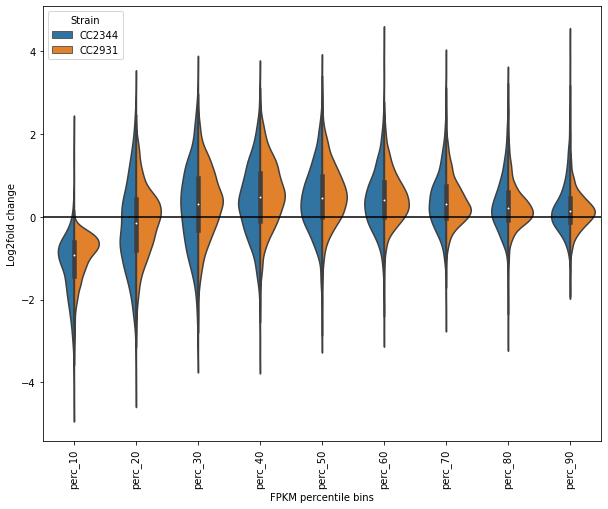

In [10]:
###### LIST OF GENES ####
CC2344 = ['CC2344-ANC', "CC2344-L1", "CC2344-L2", "CC2344-L3", "CC2344-L4", "CC2344-L5", "CC2344-L6", "CC2344-L7", "CC2344-L8", "CC2344-L9", "CC2344-L10", "CC2344-L11", "CC2344-L12", "CC2344-L13", "CC2344-L14", "CC2344-L15"]
CC2931 = ["CC2931-ANC", "CC2931-L1", "CC2931-L2", "CC2931-L3", "CC2931-L4", "CC2931-L5", "CC2931-L6", "CC2931-L7", "CC2931-L9", "CC2931-L10", "CC2931-L11", "CC2931-L13", "CC2931-L14", "CC2931-L15"]

CC2931_avg_fpkm = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/fpkm/CC2931_avg_fpkm', delimiter = '\t')
CC2344_avg_fpkm = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/fpkm/CC2344_avg_fpkm', delimiter = '\t')

CC2344_log2fold = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/raw_counts/CC2344_log2Fold', delimiter = '\t', index_col = 'Unnamed: 0')
CC2931_log2fold = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/raw_counts/CC2931_log2Fold', delimiter = '\t', index_col = 'Unnamed: 0')

CC2344_L2F_dist = {}
CC2931_L2F_dist = {}

#### DETERMINING THE LOG2FOLD SUM OF GENES WITHIN EACH FPKM PERCENTILE BIN (EXCLUDING ANCESTOR) ####
for i in CC2931_bins.keys():
    genes = CC2931_bins[i]
    CC2931_mean = CC2931_log2fold[CC2931[1:]].loc[genes].mean(axis = 1)
    CC2931_L2F_dist[i] = CC2931_mean.values.tolist()

#### DETERMINING THE LOG2FOLD SUM OF GENES WITHIN EACH FPKM PERCENTILE BIN (EXCLUDING ANCESTOR) ####
for i in CC2344_bins.keys():
    genes = CC2344_bins[i]
    CC2344_mean = CC2344_log2fold[CC2344[1:]].loc[genes].mean(axis = 1)
    CC2344_L2F_dist[i] = CC2344_mean.values.tolist()
    
CC2344_L2F_dist = pd.DataFrame(dict([(k,pd.Series(v)) for k,v in CC2344_L2F_dist.items()])).reset_index()
CC2931_L2F_dist = pd.DataFrame(dict([(k,pd.Series(v)) for k,v in CC2931_L2F_dist.items()])).reset_index()

CC2344_L2F_dist = pd.melt(CC2344_L2F_dist, id_vars = ['index'], value_vars = CC2344_L2F_dist.columns[1:])
CC2344_L2F_dist['sample'] = 'CC2344'
CC2931_L2F_dist = pd.melt(CC2931_L2F_dist, id_vars = ['index'], value_vars = CC2931_L2F_dist.columns[1:])
CC2931_L2F_dist['sample'] = 'CC2931'

L2F_dist = pd.concat([CC2344_L2F_dist, CC2931_L2F_dist])

#### PLOTTING THE SUM OF LOG2FOLD CHANGES PER FPKM PERCENTILE BINS ####
fig, ax = plt.subplots(figsize = (10, 8))
sns.violinplot(ax = ax, data = L2F_dist, x = 'variable', y = 'value', hue = 'sample', alpha = 0.2, split = True)
plt.legend(title = 'Strain', loc = 'upper left')
plt.axhline(0, color = 'black')
plt.tick_params(axis = 'x', labelrotation = 90)
plt.ylabel('Log2fold change')
plt.xlabel('FPKM percentile bins')

plt.savefig('/research/projects/chlamydomonas/MAexpression/analysis/log2fold/sum_of_log2fold_per_FPKM_percentile_bins_2.pdf', format = 'pdf', dpi = 150, bbox_inches = 'tight')

#### FLIGNER-KILLEEN STATS ####
CC2344_block = CC2344_L2F_dist.loc[CC2344_L2F_dist['sample'] == 'CC2344']
CC2931_block = CC2931_L2F_dist.loc[CC2931_L2F_dist['sample'] == 'CC2931']

fligner_stats = pd.DataFrame()
fpkm_bins = list(CC2344_block['variable'].unique())
for i in range(len(fpkm_bins) - 1):
    a = CC2344_block.loc[CC2344_block['variable'] == fpkm_bins[i]]['value'].dropna().sort_values(ascending = True).values.tolist()
    b = CC2344_block.loc[CC2344_block['variable'] == fpkm_bins[i+1]]['value'].dropna().sort_values(ascending = True).values.tolist()
    fligner_stats.at[fpkm_bins[i] + '-' + fpkm_bins[i + 1], 'CC2344_pval'] = stats.fligner(a, b)[1]
    if stats.fligner(a, b)[1] < 0.05:
        fligner_stats.at[fpkm_bins[i] + '-' + fpkm_bins[i + 1], 'CC2344_P'] = 'Reject'
    else:
        fligner_stats.at[fpkm_bins[i] + '-' + fpkm_bins[i + 1], 'CC2344_P'] = 'Fail to Reject'
    
    c = CC2931_block.loc[CC2931_block['variable'] == fpkm_bins[i]]['value'].dropna().sort_values(ascending = True).values.tolist()
    d = CC2931_block.loc[CC2931_block['variable'] == fpkm_bins[i+1]]['value'].dropna().sort_values(ascending = True).values.tolist()
    fligner_stats.at[fpkm_bins[i] + '-' + fpkm_bins[i + 1], 'CC2931_pval'] = stats.fligner(c, d)[1]
    if stats.fligner(c, d)[1] < 0.05:
        fligner_stats.at[fpkm_bins[i] + '-' + fpkm_bins[i + 1], 'CC2931_P'] = 'Reject'
    else:
        fligner_stats.at[fpkm_bins[i] + '-' + fpkm_bins[i + 1], 'CC2931_P'] = 'Fail to Reject'
display(fligner_stats)

#### BRUNNER MUNZEL STATS ####
CC2344_block = CC2344_L2F_dist.loc[CC2344_L2F_dist['sample'] == 'CC2344']
CC2931_block = CC2931_L2F_dist.loc[CC2931_L2F_dist['sample'] == 'CC2931']

brunner_munzel = pd.DataFrame()
fpkm_bins = list(CC2344_block['variable'].unique())
for i in range(len(fpkm_bins) - 1):
    a = CC2344_block.loc[CC2344_block['variable'] == fpkm_bins[i]]['value'].dropna().sort_values(ascending = True).values.tolist()
    b = CC2344_block.loc[CC2344_block['variable'] == fpkm_bins[i+1]]['value'].dropna().sort_values(ascending = True).values.tolist()
    brunner_munzel.at[fpkm_bins[i] + '-' + fpkm_bins[i + 1], 'CC2344_pval'] = scipy.stats.brunnermunzel(a, b)[1]
    if scipy.stats.brunnermunzel(a, b)[1] < 0.05:
        brunner_munzel.at[fpkm_bins[i] + '-' + fpkm_bins[i + 1], 'CC2344_P'] = 'Reject'
    else:
        brunner_munzel.at[fpkm_bins[i] + '-' + fpkm_bins[i + 1], 'CC2344_P'] = 'Fail to Reject'
    
    c = CC2931_block.loc[CC2931_block['variable'] == fpkm_bins[i]]['value'].dropna().sort_values(ascending = True).values.tolist()
    d = CC2931_block.loc[CC2931_block['variable'] == fpkm_bins[i+1]]['value'].dropna().sort_values(ascending = True).values.tolist()
    brunner_munzel.at[fpkm_bins[i] + '-' + fpkm_bins[i + 1], 'CC2931_pval'] = scipy.stats.brunnermunzel(c, d)[1]
    if scipy.stats.brunnermunzel(c, d)[1] < 0.05:
        brunner_munzel.at[fpkm_bins[i] + '-' + fpkm_bins[i + 1], 'CC2931_P'] = 'Reject'
    else:
        brunner_munzel.at[fpkm_bins[i] + '-' + fpkm_bins[i + 1], 'CC2931_P'] = 'Fail to Reject'
display(brunner_munzel)

#### STATS OF THE DISTRIBUTION OF GENES WITHIN EACH FPKM PERCENTILE BIN ####
stats = pd.DataFrame()
for i in range(len(fpkm_bins)):
    stats.at[fpkm_bins[i], 'CC2344_var'] = CC2344_block.loc[CC2344_block['variable'] == fpkm_bins[i]]['value'].dropna().sort_values(ascending = True).var()
    stats.at[fpkm_bins[i], 'CC2931_var'] = CC2931_block.loc[CC2931_block['variable'] == fpkm_bins[i]]['value'].dropna().sort_values(ascending = True).var()
    stats.at[fpkm_bins[i], 'CC2344_mean'] = CC2344_block.loc[CC2344_block['variable'] == fpkm_bins[i]]['value'].dropna().sort_values(ascending = True).mean()
    stats.at[fpkm_bins[i], 'CC2931_mean'] = CC2931_block.loc[CC2931_block['variable'] == fpkm_bins[i]]['value'].dropna().sort_values(ascending = True).mean()
    stats.at[fpkm_bins[i], 'CC2344_median'] = CC2344_block.loc[CC2344_block['variable'] == fpkm_bins[i]]['value'].dropna().sort_values(ascending = True).median()
    stats.at[fpkm_bins[i], 'CC2931_median'] = CC2931_block.loc[CC2931_block['variable'] == fpkm_bins[i]]['value'].dropna().sort_values(ascending = True).median()
display(stats)

### MUTATIONAL VARIANCE ACROSS FPKM PERCENTILE BINES

,CC2344_pval,CC2344_P,CC2931_pval,CC2931_P
perc_10-perc_20,2.966578e-05,Reject,2.892649e-08,Reject
perc_20-perc_30,8.127200e-01,Fail to Reject,8.245322e-02,Fail to Reject
perc_30-perc_40,6.685199e-03,Reject,3.506042e-03,Reject
perc_40-perc_50,6.903976e-01,Fail to Reject,4.695667e-01,Fail to Reject
perc_50-perc_60,1.736698e-01,Fail to Reject,2.252594e-01,Fail to Reject
perc_60-perc_70,1.494848e-02,Reject,2.508163e-11,Reject
perc_70-perc_80,6.026952e-06,Reject,1.559993e-20,Reject
perc_80-perc_90,4.539092e-25,Reject,5.687972e-22,Reject


,CC2344_var,CC2931_var,CC2344_mean,CC2931_mean,CC2344_median,CC2931_median
perc_10,0.000130,0.000018,0.027501,0.010227,0.026398,0.009804
perc_20,0.000099,0.000025,0.026454,0.013013,0.025234,0.012602
perc_30,0.000094,0.000027,0.025220,0.012424,0.024268,0.012131
perc_40,0.000109,0.000028,0.023474,0.011128,0.022114,0.010843
perc_50,0.000116,0.000029,0.020282,0.009735,0.018487,0.009132
perc_60,0.000106,0.000029,0.017346,0.007863,0.015108,0.006641
perc_70,0.000115,0.000028,0.014202,0.005978,0.011220,0.004111
perc_80,0.000096,0.000022,0.011249,0.004612,0.007821,0.002693
perc_90,0.000073,0.000015,0.007624,0.003535,0.004788,0.002239


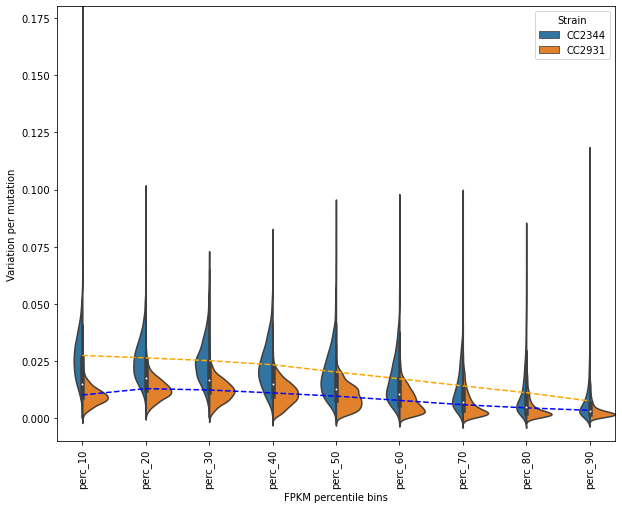

In [5]:
import scipy
from scipy import stats
from scipy.stats import fligner

###### LIST OF GENES ####
CC2344 = ['CC2344-ANC', "CC2344-L1", "CC2344-L2", "CC2344-L3", "CC2344-L4", "CC2344-L5", "CC2344-L6", "CC2344-L7", "CC2344-L8", "CC2344-L9", "CC2344-L10", "CC2344-L11", "CC2344-L12", "CC2344-L13", "CC2344-L14", "CC2344-L15"]
CC2931 = ["CC2931-ANC", "CC2931-L1", "CC2931-L2", "CC2931-L3", "CC2931-L4", "CC2931-L5", "CC2931-L6", "CC2931-L7", "CC2931-L9", "CC2931-L10", "CC2931-L11", "CC2931-L13", "CC2931-L14", "CC2931-L15"]

CC2344_Vm = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/log2fold/CC2344_mutational_variance.csv', delimiter = '\t', index_col = 'Unnamed: 0')
CC2931_Vm = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/log2fold/CC2931_mutational_variance.csv', delimiter = '\t', index_col = 'Unnamed: 0')

CC2931_avg_fpkm = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/fpkm/CC2931_avg_fpkm', delimiter = '\t')
CC2344_avg_fpkm = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/fpkm/CC2344_avg_fpkm', delimiter = '\t')

CC2344_Vm_dist = {}
CC2931_Vm_dist = {}

#### DETERMINING THE MUTATIONAL VARIANCE OF GENES WITHIN EACH FPKM PERCENTILE BIN (EXCLUDING ANCESTOR) ####
for i in CC2931_bins.keys():
    genes = CC2931_bins[i]
    CC2931_Vm_dist[i] = CC2931_Vm['Vm_per_mut'].loc[genes].values.tolist()

for i in CC2344_bins.keys():
    genes = CC2344_bins[i]
    CC2344_Vm_dist[i] = CC2344_Vm['Vm_per_mut'].loc[genes].values.tolist()
    
CC2344_Vm_dist = pd.DataFrame(dict([(k,pd.Series(v)) for k,v in CC2344_Vm_dist.items()])).reset_index()
CC2931_Vm_dist = pd.DataFrame(dict([(k,pd.Series(v)) for k,v in CC2931_Vm_dist.items()])).reset_index()

CC2931_Vm_dist = pd.melt(CC2931_Vm_dist, id_vars = ['index'], value_vars = CC2931_Vm_dist.columns[1:])
CC2931_Vm_dist['sample'] = 'CC2931'
CC2344_Vm_dist = pd.melt(CC2344_Vm_dist, id_vars = ['index'], value_vars = CC2344_Vm_dist.columns[1:])
CC2344_Vm_dist['sample'] = 'CC2344'

Vm_dist = pd.concat([CC2344_Vm_dist, CC2931_Vm_dist])

fpkm_bins = list(CC2344_bins.keys())

#### TESTING THE VARIANCE OF BINS ####
fligner_stats = pd.DataFrame()
for i in range(len(fpkm_bins) - 1):
    a = CC2344_Vm_dist.loc[CC2344_Vm_dist['variable'] == fpkm_bins[i]]['value'].dropna().sort_values(ascending = True).values.tolist()
    b = CC2344_Vm_dist.loc[CC2344_Vm_dist['variable'] == fpkm_bins[i+1]]['value'].dropna().sort_values(ascending = True).values.tolist()
    fligner_stats.at[fpkm_bins[i] + '-' + fpkm_bins[i + 1], 'CC2344_pval'] = stats.fligner(a, b)[1]
    if stats.fligner(a, b)[1] < 0.05:
        fligner_stats.at[fpkm_bins[i] + '-' + fpkm_bins[i + 1], 'CC2344_P'] = 'Reject'
    else:
        fligner_stats.at[fpkm_bins[i] + '-' + fpkm_bins[i + 1], 'CC2344_P'] = 'Fail to Reject'
    
    c = CC2931_Vm_dist.loc[CC2931_Vm_dist['variable'] == fpkm_bins[i]]['value'].dropna().sort_values(ascending = True).values.tolist()
    d = CC2931_Vm_dist.loc[CC2931_Vm_dist['variable'] == fpkm_bins[i+1]]['value'].dropna().sort_values(ascending = True).values.tolist()
    fligner_stats.at[fpkm_bins[i] + '-' + fpkm_bins[i + 1], 'CC2931_pval'] = stats.fligner(c, d)[1]
    if stats.fligner(c, d)[1] < 0.05:
        fligner_stats.at[fpkm_bins[i] + '-' + fpkm_bins[i + 1], 'CC2931_P'] = 'Reject'
    else:
        fligner_stats.at[fpkm_bins[i] + '-' + fpkm_bins[i + 1], 'CC2931_P'] = 'Fail to Reject'
display(fligner_stats)

stats = pd.DataFrame()
for i in range(len(fpkm_bins)):
    stats.at[fpkm_bins[i], 'CC2344_var'] = CC2344_Vm_dist.loc[CC2344_Vm_dist['variable'] == fpkm_bins[i]]['value'].dropna().sort_values(ascending = True).var()
    stats.at[fpkm_bins[i], 'CC2931_var'] = CC2931_Vm_dist.loc[CC2931_Vm_dist['variable'] == fpkm_bins[i]]['value'].dropna().sort_values(ascending = True).var()
    stats.at[fpkm_bins[i], 'CC2344_mean'] = CC2344_Vm_dist.loc[CC2344_Vm_dist['variable'] == fpkm_bins[i]]['value'].dropna().sort_values(ascending = True).mean()
    stats.at[fpkm_bins[i], 'CC2931_mean'] = CC2931_Vm_dist.loc[CC2931_Vm_dist['variable'] == fpkm_bins[i]]['value'].dropna().sort_values(ascending = True).mean()
    stats.at[fpkm_bins[i], 'CC2344_median'] = CC2344_Vm_dist.loc[CC2344_Vm_dist['variable'] == fpkm_bins[i]]['value'].dropna().sort_values(ascending = True).median()
    stats.at[fpkm_bins[i], 'CC2931_median'] = CC2931_Vm_dist.loc[CC2931_Vm_dist['variable'] == fpkm_bins[i]]['value'].dropna().sort_values(ascending = True).median()
display(stats)

#### PLOTTING THE MUTATIONAL VARIANCE PER FPKM PERCENTILE BINS ####
fig, ax = plt.subplots(figsize = (10, 8))
sns.violinplot(ax = ax, data = Vm_dist, x = 'variable', y = 'value', hue = 'sample', alpha = 0.2, split = True)
plt.legend(title = 'Strain', loc = 'upper right')
plt.tick_params(axis = 'x', labelrotation = 90)
plt.ylim(-0.01, 0.18)
plt.ylabel('Variation per mutation')
plt.xlabel('FPKM percentile bins')

for i in range(len(fpkm_bins) - 1):
    a = fpkm_bins[i]
    b = fpkm_bins[i+1]
    plt.plot([a, b],[stats.at[a, 'CC2344_mean'], stats.at[b, 'CC2344_mean']], color = 'orange', linestyle = 'dashed')
    plt.plot([a, b],[stats.at[a, 'CC2931_mean'], stats.at[b, 'CC2931_mean']], color = 'blue', linestyle = 'dashed')
plt.savefig('/research/projects/chlamydomonas/MAexpression/analysis/log2fold/Vm_per_fpkm.pdf', format = 'pdf', bbox_inches = 'tight', dpi = 150)

### ABSOLUTE VALUE LOG2FOLD CHANGE AMONG FPKM BINS

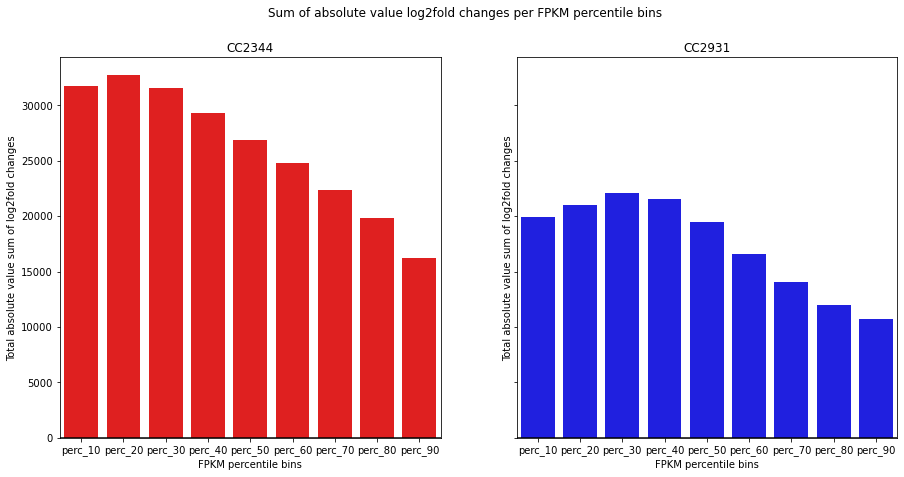

In [33]:
#### LIST OF GENES ####
CC2344 = ['CC2344-ANC', "CC2344-L1", "CC2344-L2", "CC2344-L3", "CC2344-L4", "CC2344-L5", "CC2344-L6", "CC2344-L7", "CC2344-L8", "CC2344-L9", "CC2344-L10", "CC2344-L11", "CC2344-L12", "CC2344-L13", "CC2344-L14", "CC2344-L15"]
CC2931 = ["CC2931-ANC", "CC2931-L1", "CC2931-L2", "CC2931-L3", "CC2931-L4", "CC2931-L5", "CC2931-L6", "CC2931-L7", "CC2931-L9", "CC2931-L10", "CC2931-L11", "CC2931-L13", "CC2931-L14", "CC2931-L15"]

#### CREATING DATAFRAMES ####
for i in ['CC2931_log2fold', 'CC2344_log2fold', 'CC2344_fpkm_bins', 'CC2931_fpkm_bins']:
    exec('{} = pd.DataFrame()'.format(i))

CC2931_avg_fpkm = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/fpkm/CC2931_avg_fpkm', delimiter = '\t')
CC2344_avg_fpkm = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/fpkm/CC2344_avg_fpkm', delimiter = '\t')

for i in CC2931[1:]:
    CC2931_log2fold[i] = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/genes_log2fold/' + i, delimiter = "\t")['log2FoldChange']
for i in CC2344[1:]:
    CC2344_log2fold[i] = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/genes_log2fold/' + i, delimiter = "\t")['log2FoldChange']

#### TAKING THE ABSOLUTE VALUE OF LOG2FOLD ####
CC2931_log2fold = CC2931_log2fold.abs()
CC2344_log2fold = CC2344_log2fold.abs()

#### DETERMINING THE LOG2FOLD SUM OF GENES WITHIN EACH FPKM PERCENTILE BIN (EXCLUDING ANCESTOR) ####
for i in CC2931_bins.keys():
    genes = CC2931_bins[i]
    CC2931_sum = CC2931_log2fold[CC2931[1:]].loc[genes].sum(axis = 1)
    CC2931_fpkm_bins.at[i, 'bins'] = CC2931_sum.sum()

#### DETERMINING THE LOG2FOLD SUM OF GENES WITHIN EACH FPKM PERCENTILE BIN (EXCLUDING ANCESTOR) ####
for i in CC2344_bins.keys():
    genes = CC2344_bins[i]
    CC2344_sum = CC2344_log2fold[CC2344[1:]].loc[genes].sum(axis = 1)
    CC2344_fpkm_bins.at[i, 'bins'] = CC2344_sum.sum()
    
#### PLOTTING THE SUM OF LOG2FOLD CHANGES PER FPKM PERCENTILE BINS ####
CC2344_fpkm_bins = CC2344_fpkm_bins.reset_index()
CC2931_fpkm_bins = CC2931_fpkm_bins.reset_index()

fig, axes = plt.subplots(1, 2, figsize=(15, 7), sharey=True)
fig.suptitle('Sum of absolute value log2fold changes per FPKM percentile bins')

ax1 = sns.barplot(ax = axes[0], data = CC2344_fpkm_bins, x = 'index', y = 'bins', color = 'red')
ax1.set_xlabel('FPKM percentile bins')
ax1.set_ylabel('Total absolute value sum of log2fold changes')
ax1.axhline(0, color = 'black')
ax1.set_title('CC2344')
ax2 = sns.barplot(ax = axes[1], data = CC2931_fpkm_bins, x = 'index', y = 'bins', color = 'blue')
ax2.set_xlabel('FPKM percentile bins')
ax2.set_ylabel('Total absolute value sum of log2fold changes')
ax2.axhline(0, color = 'black')
ax2.set_title('CC2931')

plt.savefig('/research/projects/chlamydomonas/MAexpression/analysis/log2fold/sum_of_absval_log2fold_per_FPKM_percentile_bins.pdf', format = 'pdf', dpi = 150, bbox_inches = 'tight')

### ABSOLUTE FOLD CHANGE AMONG FPKM BINS

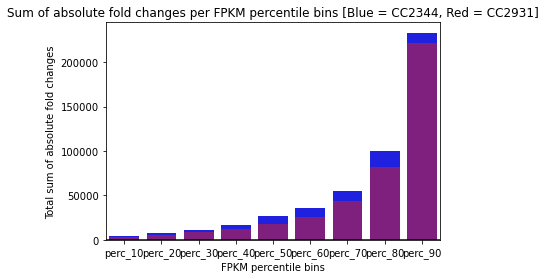

In [34]:
#### OPENING FILES ####
for i in ['CC2344_fpkm_bins', 'CC2931_fpkm_bins']:
    exec('{} = pd.DataFrame()'.format(i))
    
CC2344 = ['CC2344-ANC', "CC2344-L1", "CC2344-L2", "CC2344-L3", "CC2344-L4", "CC2344-L5", "CC2344-L6", "CC2344-L7", "CC2344-L8", "CC2344-L9", "CC2344-L10", "CC2344-L11", "CC2344-L12", "CC2344-L13", "CC2344-L14", "CC2344-L15"]
CC2931 = ["CC2931-ANC", "CC2931-L1", "CC2931-L2", "CC2931-L3", "CC2931-L4", "CC2931-L5", "CC2931-L6", "CC2931-L7", "CC2931-L9", "CC2931-L10", "CC2931-L11", "CC2931-L13", "CC2931-L14", "CC2931-L15"]

CC2931_raw = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/raw_counts/CC2931_abs', delimiter = '\t', index_col = 'Unnamed: 0')
CC2344_raw = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/raw_counts/CC2344_abs', delimiter = '\t', index_col = 'Unnamed: 0')
        
#### DETERMINING THE ABSOLUTE FOLD SUM OF GENES WITHIN EACH FPKM PERCENTILE BIN (EXCLUDING ANCESTOR) ####
for i in CC2344_bins.keys():
    genes = CC2344_bins[i]
    CC2344_sum = CC2344_raw[CC2344[1:]].loc[genes].sum(axis = 1)
    CC2344_fpkm_bins.at[i, 'bins'] = CC2344_sum.sum()
    
for i in CC2931_bins.keys():
    genes = CC2931_bins[i]
    CC2931_sum = CC2931_raw[CC2931[1:]].loc[genes].sum(axis = 1)
    CC2931_fpkm_bins.at[i, 'bins'] = CC2931_sum.sum()
    
#### PLOTTING THE SUM OF ABSOLUTE FOLD CHANGES PER FPKM PERCENTILE BINS #####
CC2344_fpkm_bins = CC2344_fpkm_bins.reset_index()
CC2931_fpkm_bins = CC2931_fpkm_bins.reset_index()
sns.barplot(data = CC2344_fpkm_bins, x = 'index', y = 'bins', color = 'blue')
sns.barplot(data = CC2931_fpkm_bins, x = 'index', y = 'bins', color = 'red', alpha = 0.5)
plt.xlabel('FPKM percentile bins')
plt.ylabel('Total sum of absolute fold changes')
plt.axhline(0, color = 'black')
plt.title('Sum of absolute fold changes per FPKM percentile bins [Blue = CC2344, Red = CC2931]')
plt.savefig('/research/projects/chlamydomonas/MAexpression/analysis/absolute_fold_change/sum_of_absolute_fold_per_FPKM_percentile_bins.pdf', format = 'pdf', dpi = 150, bbox_inches = 'tight')

### RELATIVE FOLD CHANGE AMONG FPKM BINS

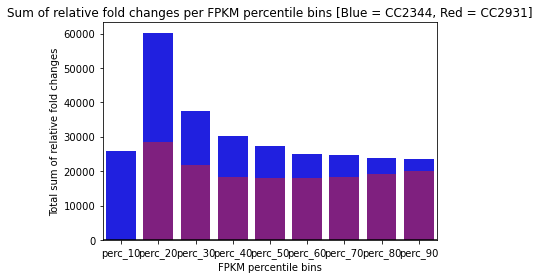

In [35]:
#### OPENING FILES ####
for i in ['CC2344_fpkm_bins', 'CC2931_fpkm_bins']:
    exec('{} = pd.DataFrame()'.format(i))
    
CC2344 = ['CC2344-ANC', "CC2344-L1", "CC2344-L2", "CC2344-L3", "CC2344-L4", "CC2344-L5", "CC2344-L6", "CC2344-L7", "CC2344-L8", "CC2344-L9", "CC2344-L10", "CC2344-L11", "CC2344-L12", "CC2344-L13", "CC2344-L14", "CC2344-L15"]
CC2931 = ["CC2931-ANC", "CC2931-L1", "CC2931-L2", "CC2931-L3", "CC2931-L4", "CC2931-L5", "CC2931-L6", "CC2931-L7", "CC2931-L9", "CC2931-L10", "CC2931-L11", "CC2931-L13", "CC2931-L14", "CC2931-L15"]
    
CC2931_raw = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/raw_counts/CC2931_rel', delimiter = '\t', index_col = 'Unnamed: 0')
CC2344_raw = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/raw_counts/CC2344_rel', delimiter = '\t', index_col = 'Unnamed: 0')

#### DETERMINING THE RELATIVE FOLD SUM OF GENES WITHIN EACH FPKM PERCENTILE BIN (EXCLUDING ANCESTOR) ####
for i in CC2344_bins.keys():
    genes = CC2344_bins[i]
    genes = set.intersection(set(genes), set(list(CC2344_raw.index.values)))
    CC2344_sum = CC2344_raw[CC2344[1:]].loc[genes].sum(axis = 1)
    CC2344_fpkm_bins.at[i, 'bins'] = CC2344_sum.sum()
    
for i in CC2931_bins.keys():
    genes = CC2931_bins[i]
    genes = set.intersection(set(genes), set(list(CC2931_raw.index.values)))
    CC2931_sum = CC2931_raw[CC2931[1:]].loc[genes].sum(axis = 1)
    CC2931_fpkm_bins.at[i, 'bins'] = CC2931_sum.sum()
    
#### PLOTTING THE SUM OF RELATIVE FOLD CHANGES PER FPKM PERCENTILE BINS #####
CC2344_fpkm_bins = CC2344_fpkm_bins.reset_index()
CC2931_fpkm_bins = CC2931_fpkm_bins.reset_index()
sns.barplot(data = CC2344_fpkm_bins, x = 'index', y = 'bins', color = 'blue')
sns.barplot(data = CC2931_fpkm_bins, x = 'index', y = 'bins', color = 'red', alpha = 0.5)
plt.xlabel('FPKM percentile bins')
plt.ylabel('Total sum of relative fold changes')
plt.axhline(0, color = 'black')
plt.title('Sum of relative fold changes per FPKM percentile bins [Blue = CC2344, Red = CC2931]')
plt.savefig('/research/projects/chlamydomonas/MAexpression/analysis/relative_fold_change/sum_of_relative_fold_per_FPKM_percentile_bins.pdf', format = 'pdf', dpi = 150, bbox_inches = 'tight')

### DEGS ACROSS FPKM BINS

<ipython-input-36-17bb57a72a66>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CC2344_DEGs['variable'] = CC2344_DEGs['variable'].replace(CC2344_dic, regex = True)
/home/balogu15/.conda/envs/personal/lib/python3.8/site-packages/pandas/core/indexing.py:1599: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
/home/balogu15/.conda/envs/personal/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

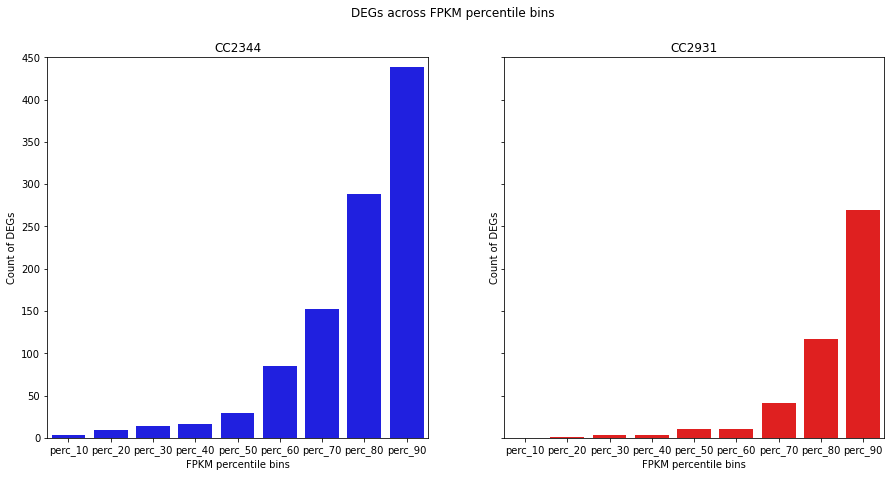

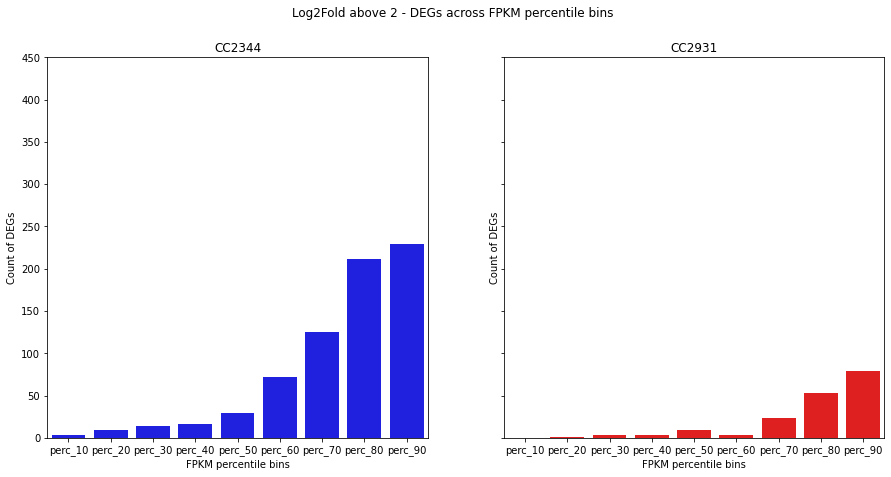

In [36]:
CC2344 = ["CC2344-L1", "CC2344-L2", "CC2344-L3", "CC2344-L4", "CC2344-L5", "CC2344-L6", "CC2344-L7", "CC2344-L8", "CC2344-L9", "CC2344-L10", "CC2344-L11", "CC2344-L12", "CC2344-L13", "CC2344-L14", "CC2344-L15"]
CC2931 = ["CC2931-L1", "CC2931-L2", "CC2931-L3", "CC2931-L4", "CC2931-L5", "CC2931-L6", "CC2931-L7", "CC2931-L9", "CC2931-L10", "CC2931-L11", "CC2931-L13", "CC2931-L14", "CC2931-L15"]

CC2344_genes = ['CC2344.resSig_L1.genes', 'CC2344.resSig_L2.genes', 'CC2344.resSig_L3.genes', 'CC2344.resSig_L4.genes',
                'CC2344.resSig_L5.genes', 'CC2344.resSig_L6.genes', 'CC2344.resSig_L7.genes', 'CC2344.resSig_L8.genes',
                'CC2344.resSig_L9.genes', 'CC2344.resSig_L10.genes', 'CC2344.resSig_L11.genes', 'CC2344.resSig_L12.genes',
                'CC2344.resSig_L13.genes', 'CC2344.resSig_L14.genes', 'CC2344.resSig_L15.genes']
CC2931_genes = ['CC2931.resSig_L1.genes', 'CC2931.resSig_L2.genes', 'CC2931.resSig_L3.genes', 'CC2931.resSig_L4.genes', 
                'CC2931.resSig_L5.genes', 'CC2931.resSig_L6.genes', 'CC2931.resSig_L7.genes', 'CC2931.resSig_L9.genes', 
                'CC2931.resSig_L10.genes', 'CC2931.resSig_L11.genes', 'CC2931.resSig_L13.genes', 'CC2931.resSig_L14.genes',
                'CC2931.resSig_L15.genes']
CC2344_dic = {CC2344_genes[i]:CC2344[i] for i in range(len(CC2344_genes))}
CC2931_dic = {CC2931_genes[i]:CC2931[i] for i in range(len(CC2931_genes))}

#### OPENING FILES ####
for i in ['CC2344_fpkm_bins', 'CC2931_fpkm_bins']:
    exec('{} = pd.DataFrame()'.format(i))
    
CC2344_log2Fold = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/raw_counts/CC2344_log2Fold', delimiter = '\t', index_col = 'Unnamed: 0')
CC2931_log2Fold = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/raw_counts/CC2931_log2Fold', delimiter = '\t', index_col = 'Unnamed: 0')
    
DEGs = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/DEGs/total_genes.csv', delimiter = ',')
DEGs = DEGs.reset_index()
DEGs = pd.melt(DEGs, id_vars = 'index', value_vars = DEGs.columns[1:])
DEGs = DEGs.dropna()

#### ISOLATING THE LOG2FOLD CHANGE OF EACH DEGS ####
CC2344_DEGs = DEGs.loc[DEGs['variable'].isin(CC2344_genes)]
CC2344_DEGs['variable'] = CC2344_DEGs['variable'].replace(CC2344_dic, regex = True)
for i in CC2344_DEGs.index.values:
    CC2344_DEGs.at[i, 'L2F'] = CC2344_log2Fold.at[CC2344_DEGs.at[i, 'value'], CC2344_DEGs.at[i, 'variable']]
CC2344_DEGs_L2F_above_2 = CC2344_DEGs.loc[abs(CC2344_DEGs['L2F']) >= 2]

CC2931_DEGs = DEGs.loc[DEGs['variable'].isin(CC2931_genes)]
CC2931_DEGs['variable'] = CC2931_DEGs['variable'].replace(CC2931_dic, regex = True)
for i in CC2931_DEGs.index.values:
    CC2931_DEGs.at[i, 'L2F'] = CC2931_log2Fold.at[CC2931_DEGs.at[i, 'value'], CC2931_DEGs.at[i, 'variable']]
CC2931_DEGs_L2F_above_2 = CC2931_DEGs.loc[abs(CC2931_DEGs['L2F']) >= 2]

#### DETERMINING THE DEGs WITHIN EACH FPKM PERCENTILE BIN (EXCLUDING ANCESTOR) ####
for i in CC2344_bins.keys():
    genes = CC2344_bins[i]
    genes = set.intersection(set(genes), set(CC2344_DEGs['value'].tolist()))
    CC2344_fpkm_bins.at[i, 'bins'] = len(genes)
    
for i in CC2931_bins.keys():
    genes = CC2931_bins[i]
    genes = set.intersection(set(genes), set(CC2931_DEGs['value'].tolist()))
    CC2931_fpkm_bins.at[i, 'bins'] = len(genes)
    
#### PLOTTING THE QUANTITY OF DEGs PER FPKM PERCENTILE BINS #####
CC2344_fpkm_bins = CC2344_fpkm_bins.reset_index()
CC2931_fpkm_bins = CC2931_fpkm_bins.reset_index()

fig, axes = plt.subplots(1, 2, figsize = (15, 7), sharey = True)
fig.suptitle('DEGs across FPKM percentile bins')

ax1 = sns.barplot(ax = axes[0], data = CC2344_fpkm_bins, x = 'index', y = 'bins', color = 'blue')
ax1.set_xlabel('FPKM percentile bins')
ax1.set_ylabel('Count of DEGs')
ax1.set_title('CC2344')
ax1.set_ylim(0, 450)
ax2 = sns.barplot(ax = axes[1], data = CC2931_fpkm_bins, x = 'index', y = 'bins', color = 'red')
ax2.set_xlabel('FPKM percentile bins')
ax2.set_ylabel('Count of DEGs')
ax2.set_title('CC2931')
ax2.set_ylim(0, 450)

plt.savefig('/research/projects/chlamydomonas/MAexpression/analysis/fpkm/degs_counts_per_FPKM_percentile_bins.pdf', format = 'pdf', dpi = 150, bbox_inches = 'tight')

for i in ['CC2344_fpkm_bins', 'CC2931_fpkm_bins']:
    exec('{} = pd.DataFrame()'.format(i))
    
#### DETERMINING THE DEGs ABOVE 2 L2F WITHIN EACH FPKM PERCENTILE BIN (EXCLUDING ANCESTOR) ####
for i in CC2344_bins.keys():
    genes = CC2344_bins[i]
    genes = set.intersection(set(genes), set(CC2344_DEGs_L2F_above_2['value'].tolist()))
    CC2344_fpkm_bins.at[i, 'bins'] = len(genes)
    
for i in CC2931_bins.keys():
    genes = CC2931_bins[i]
    genes = set.intersection(set(genes), set(CC2931_DEGs_L2F_above_2['value'].tolist()))
    CC2931_fpkm_bins.at[i, 'bins'] = len(genes)
    
#### PLOTTING THE QUANTITY OF DEGs PER FPKM PERCENTILE BINS #####
CC2344_fpkm_bins = CC2344_fpkm_bins.reset_index()
CC2931_fpkm_bins = CC2931_fpkm_bins.reset_index()

fig, axes = plt.subplots(1, 2, figsize = (15, 7), sharey = True)
fig.suptitle('Log2Fold above 2 - DEGs across FPKM percentile bins')

ax1 = sns.barplot(ax = axes[0], data = CC2344_fpkm_bins, x = 'index', y = 'bins', color = 'blue')
ax1.set_xlabel('FPKM percentile bins')
ax1.set_ylabel('Count of DEGs')
ax1.set_title('CC2344')
ax1.set_ylim(0, 450)
ax2 = sns.barplot(ax = axes[1], data = CC2931_fpkm_bins, x = 'index', y = 'bins', color = 'red')
ax2.set_xlabel('FPKM percentile bins')
ax2.set_ylabel('Count of DEGs')
ax2.set_title('CC2931')
ax2.set_ylim(0, 450)
plt.savefig('/research/projects/chlamydomonas/MAexpression/analysis/fpkm/degs_counts_per_FPKM_percentile_bins_L2F_above2.pdf', format = 'pdf', dpi = 150, bbox_inches = 'tight')

### K0:K4 OVER FPKM BINS

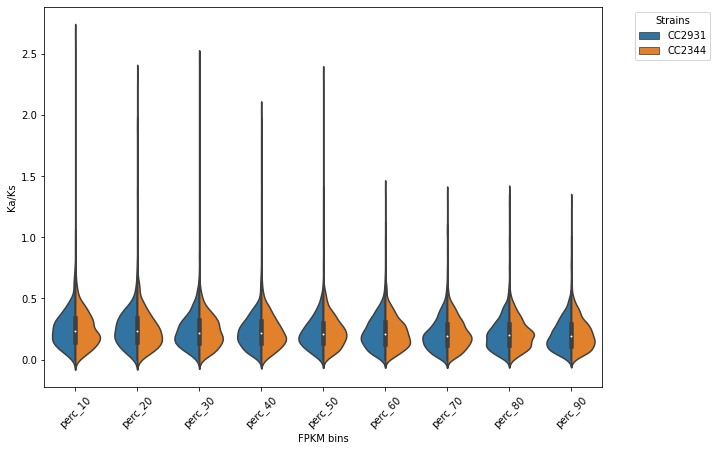

In [3]:
#### OPENING FILES ####
CC2931_avg_fpkm = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/fpkm/CC2931_avg_fpkm', delimiter = '\t')
CC2344_avg_fpkm = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/fpkm/CC2344_avg_fpkm', delimiter = '\t')
divergence = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/divergence/files/edited_divergence_info.txt', delimiter = '\t')
median_results = pd.DataFrame()
CC2344_dic = {}
CC2931_dic = {}

#### DETERMINING THE DISTRIBUTION OF K0:K4 WITHIN EACH FPKM PERCENTILE BIN ####
for i in CC2344_bins.keys():
    genes = CC2344_bins[i]
    genes = set.intersection(set(genes), set(divergence['v6'].tolist()))
    section = divergence.loc[divergence['v6'].isin(list(genes))]
    median_results.at['CC2344_' + i, 'median'] = section['k0:k4'].median()
    CC2344_dic[i] = section['k0:k4'].values.tolist()
CC2344_fpkm_bins = pd.DataFrame({ key:pd.Series(value) for key, value in CC2344_dic.items() })
CC2344_fpkm_bins = pd.melt(CC2344_fpkm_bins, value_vars = CC2344_bins.keys(), var_name = 'bins', value_name = 'k0:k4')

for i in CC2931_bins.keys():
    genes = CC2931_bins[i]
    genes = set.intersection(set(genes), set(divergence['v6'].tolist()))
    section = divergence.loc[divergence['v6'].isin(list(genes))]
    median_results.at['CC2931_' + i, 'median'] = section['k0:k4'].median()
    CC2931_dic[i] = section['k0:k4'].values.tolist()
CC2931_fpkm_bins = pd.DataFrame({ key:pd.Series(value) for key, value in CC2931_dic.items() })
CC2931_fpkm_bins = pd.melt(CC2931_fpkm_bins, value_vars = CC2931_bins.keys(), var_name = 'bins', value_name = 'k0:k4')

CC2931_fpkm_bins['sample'] = 'CC2931'
CC2344_fpkm_bins['sample'] = 'CC2344'
combined_fpkm = pd.concat([CC2931_fpkm_bins, CC2344_fpkm_bins])

#### PLOTTING THE DISTRIBUTION OF K0:K4 PER FPKM PERCENTILE BINS #####
plt.figure(figsize = (10, 7))
sns.violinplot(data = combined_fpkm, x = 'bins', y = 'k0:k4', hue = 'sample', alpha = 0.2, split = True)
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left', title = 'Strains')
plt.xticks(rotation=45)
plt.ylabel('Ka/Ks')
plt.xlabel('FPKM bins')
plt.savefig('/research/projects/chlamydomonas/MAexpression/analysis/divergence/boxplot_fpkm_vs_k0:k4.pdf', format = 'pdf', dpi = 150, bbox_inches = 'tight')

#### CHECKING THE SIGNIFICANCE OF K0:K4 DISTRIBUTION BETWEEN FPKM BINS ####
results = pd.DataFrame()
lis = [i for i in CC2344_dic.keys()]
for i in range(len(lis[:-1])): ## All of the distributions were significantly different from each other
    tstat, pval = mannwhitneyu(CC2344_dic[lis[i]], CC2344_dic[lis[i+1]], alternative = 'greater')
    results.at[lis[i] + '-' + lis[i+1], 'CC2344_alt_great'] = pval
    tstat, pval = mannwhitneyu(CC2931_dic[lis[i]], CC2931_dic[lis[i+1]], alternative = 'greater')
    results.at[lis[i] + '-' + lis[i+1], 'CC2931_alt_great'] = pval
    
    tstat, pval = mannwhitneyu(CC2344_dic[lis[i]], CC2344_dic[lis[i+1]], alternative = 'less')
    results.at[lis[i] + '-' + lis[i+1], 'CC2344_alt_less'] = pval
    tstat, pval = mannwhitneyu(CC2931_dic[lis[i]], CC2931_dic[lis[i+1]], alternative = 'less')
    results.at[lis[i] + '-' + lis[i+1], 'CC2931_alt_less'] = pval
    
display(results)
display(median_results)